In [2]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
from models.deepflybrain import DeepFlyBrain

device = torch.device(f'cuda:0')
print(f"Using {device} device")

Using cuda:0 device


In [4]:
with open('configs/config_ctdnsmpl_top3k.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

'checkpoints/dfb_ctdnsmpl_3k_2025-05-29_08-19-12'

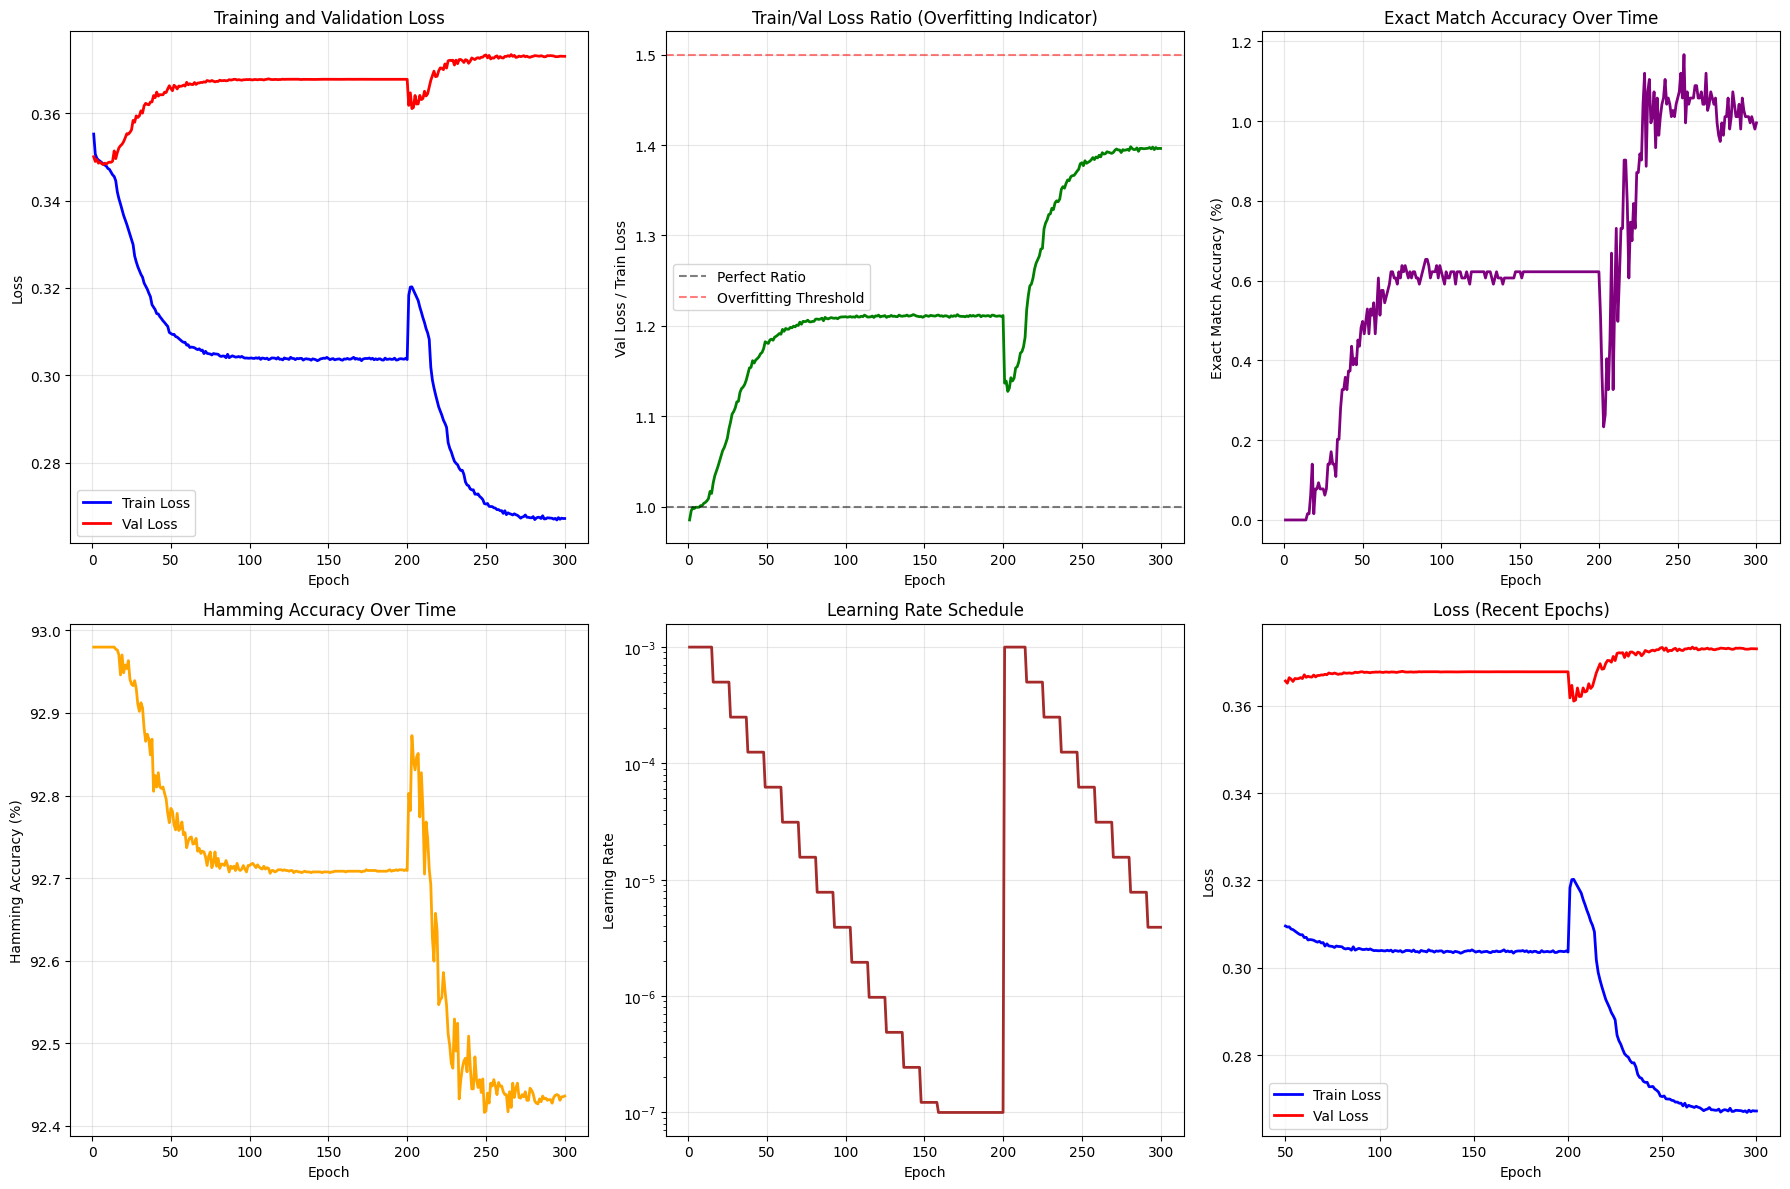

Training Summary:
Initial Train Loss: 0.355254
Final Train Loss: 0.267197
Initial Val Loss: 0.350063
Final Val Loss: 0.373062
Best Val Loss: 0.348257 (Epoch 7)
Best Exact Match Acc: 0.0117 (Epoch 254)
Best Hamming Acc: 0.9298 (Epoch 1)
Final Train/Val Ratio: 1.396


In [5]:
# Add this cell to your notebook to plot training curves

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

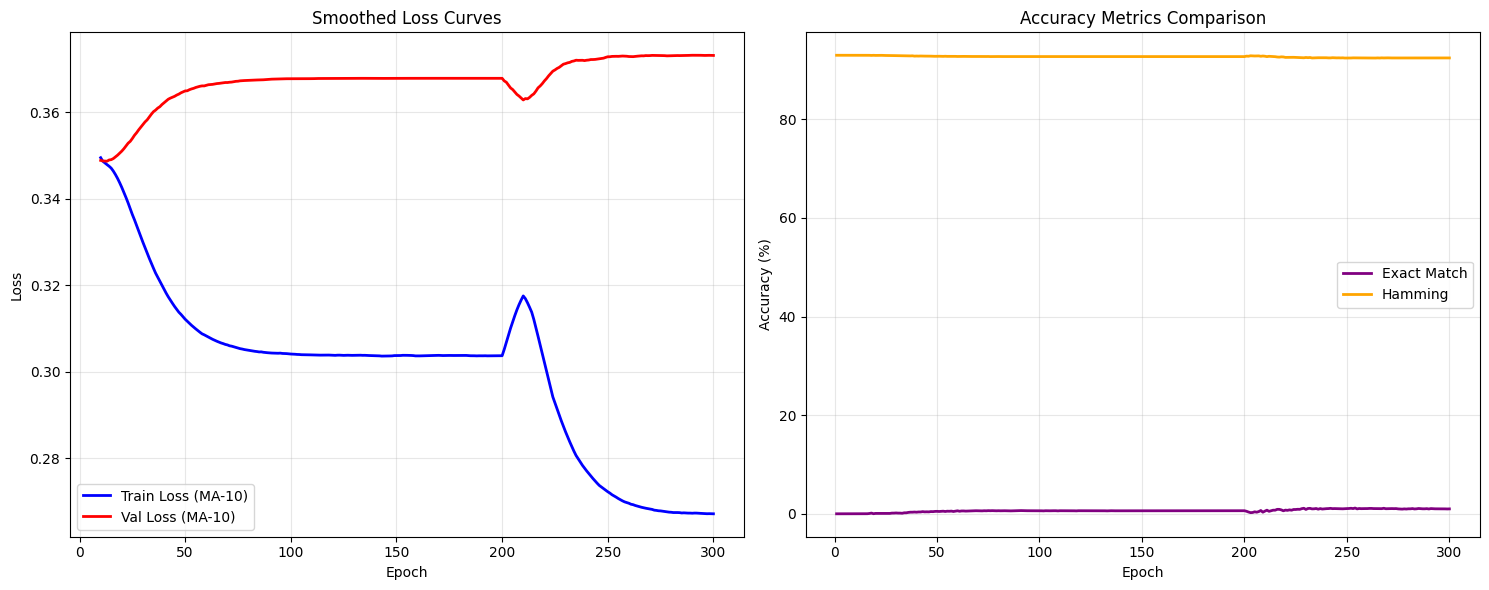

In [6]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

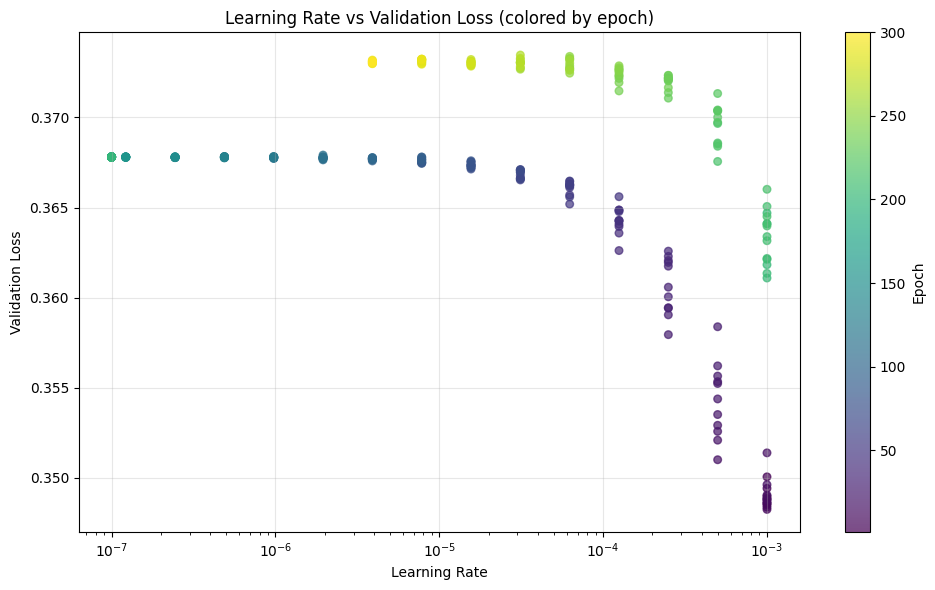

In [7]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [8]:
# Training phases analysis
print("Training Phases Analysis:")
print("=" * 50)

# Phase 1: Initial training (epochs 1-50)
phase1 = training_df[training_df['epoch'] <= 50]
print(f"Phase 1 (Epochs 1-50):")
print(f"  Loss reduction: {phase1['train_loss'].iloc[0]:.4f} → {phase1['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase1['val_loss'].iloc[0]:.4f} → {phase1['val_loss'].iloc[-1]:.4f}")
print(f"  Accuracy improvement: {phase1['exact_match_acc'].iloc[0]:.4f} → {phase1['exact_match_acc'].iloc[-1]:.4f}")

# Phase 2: Middle training (epochs 51-200)
phase2 = training_df[(training_df['epoch'] > 50) & (training_df['epoch'] <= 200)]
print(f"\nPhase 2 (Epochs 51-200):")
print(f"  Loss reduction: {phase2['train_loss'].iloc[0]:.4f} → {phase2['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase2['val_loss'].iloc[0]:.4f} → {phase2['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase2['exact_match_acc'].max():.4f}")

# Phase 3: Fine-tuning (epochs 201-300)
phase3 = training_df[training_df['epoch'] > 200]
print(f"\nPhase 3 (Epochs 201-300):")
print(f"  Loss reduction: {phase3['train_loss'].iloc[0]:.4f} → {phase3['train_loss'].iloc[-1]:.4f}")
print(f"  Val loss reduction: {phase3['val_loss'].iloc[0]:.4f} → {phase3['val_loss'].iloc[-1]:.4f}")
print(f"  Best accuracy: {phase3['exact_match_acc'].max():.4f}")

# Identify potential overfitting
overfitting_epochs = training_df[training_df['train_val_ratio'] > 1.5]
if len(overfitting_epochs) > 0:
    print(f"\nPotential overfitting detected in {len(overfitting_epochs)} epochs:")
    print(f"  First occurrence: Epoch {overfitting_epochs['epoch'].iloc[0]}")
    print(f"  Worst ratio: {overfitting_epochs['train_val_ratio'].max():.3f} at epoch {overfitting_epochs.loc[overfitting_epochs['train_val_ratio'].idxmax(), 'epoch']}")
else:
    print(f"\nNo significant overfitting detected (all ratios < 1.5)")

Training Phases Analysis:
Phase 1 (Epochs 1-50):
  Loss reduction: 0.3553 → 0.3096
  Val loss reduction: 0.3501 → 0.3657
  Accuracy improvement: 0.0000 → 0.0050

Phase 2 (Epochs 51-200):
  Loss reduction: 0.3093 → 0.3036
  Val loss reduction: 0.3652 → 0.3678
  Best accuracy: 0.0065

Phase 3 (Epochs 201-300):
  Loss reduction: 0.3183 → 0.2672
  Val loss reduction: 0.3618 → 0.3731
  Best accuracy: 0.0117

No significant overfitting detected (all ratios < 1.5)


In [9]:
# Resume model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/model_epoch_200.pth')

model = DeepFlyBrain(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [11]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [12]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [14]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.0017318239 0.9908901
Prediction shape: (42863, 18)
Target shape: (42863, 18)


In [15]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0700
Topic 1: 0.0700
Topic 2: 0.0700
Topic 3: 0.0700
Topic 4: 0.0700
Topic 5: 0.0700
Topic 6: 0.0700
Topic 7: 0.0700
Topic 8: 0.0700
Topic 9: 0.0700
Topic 10: 0.0700
Topic 11: 0.0700
Topic 12: 0.0700
Topic 13: 0.0700
Topic 14: 0.0699
Topic 15: 0.0700
Topic 16: 0.0700
Topic 17: 0.0700


In [16]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[39722   141]
 [ 2208   792]]

Topic 1:
[[39768    96]
 [ 1532  1467]]

Topic 2:
[[39858     5]
 [ 2887   113]]

Topic 3:
[[39820    44]
 [ 2076   923]]

Topic 4:
[[39728   135]
 [ 2033   967]]

Topic 5:
[[39847    16]
 [ 2599   401]]

Topic 6:
[[39716   147]
 [ 2126   874]]

Topic 7:
[[39844    19]
 [ 2667   333]]

Topic 8:
[[39852    12]
 [ 2778   221]]

Topic 9:
[[39828    35]
 [ 2586   414]]

Topic 10:
[[39812    51]
 [ 2405   595]]

Topic 11:
[[39809    54]
 [ 2389   611]]

Topic 12:
[[39861     2]
 [ 2918    82]]

Topic 13:
[[39673   190]
 [ 1826  1174]]

Topic 14:
[[39844    21]
 [ 2658   340]]

Topic 15:
[[39851    12]
 [ 2762   238]]

Topic 16:
[[39832    31]
 [ 2372   628]]

Topic 17:
[[39857     6]
 [ 2824   176]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.8726, auPR: 0.5672, F1: 0.4027


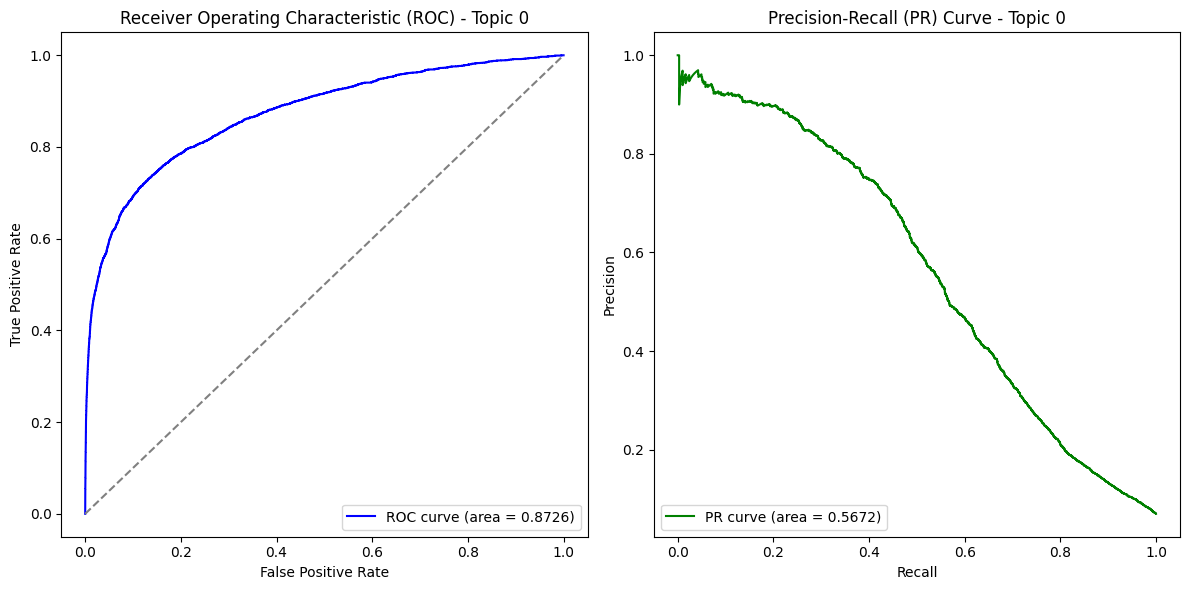

Evaluating topic 1
Topic 1 - auROC: 0.9015, auPR: 0.7530, F1: 0.6431


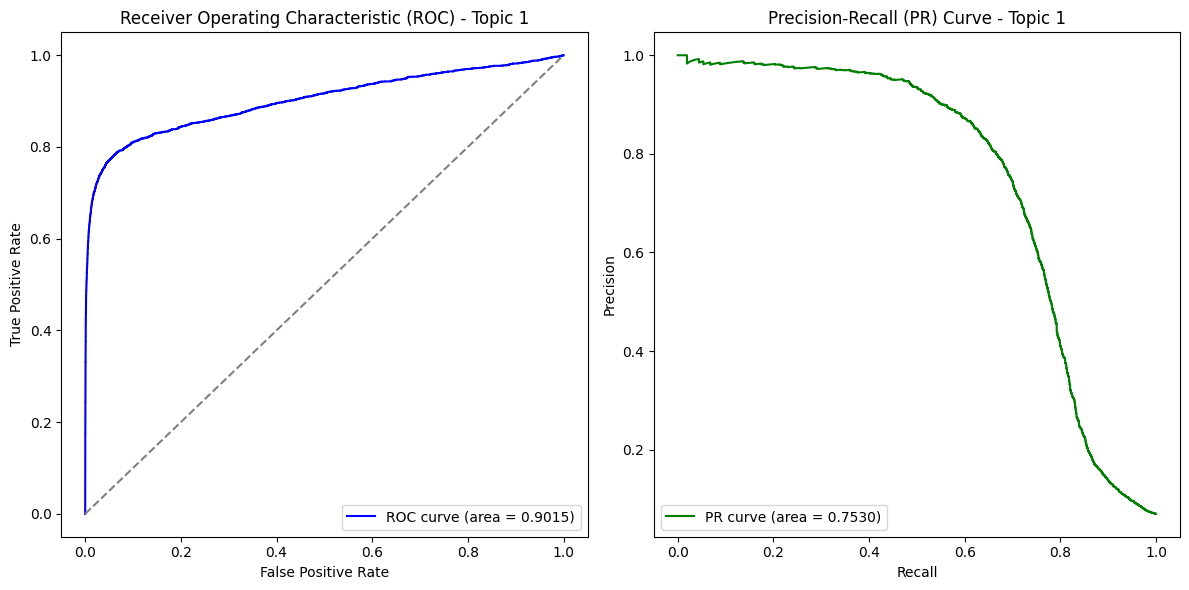

Evaluating topic 2
Topic 2 - auROC: 0.8392, auPR: 0.4835, F1: 0.0725


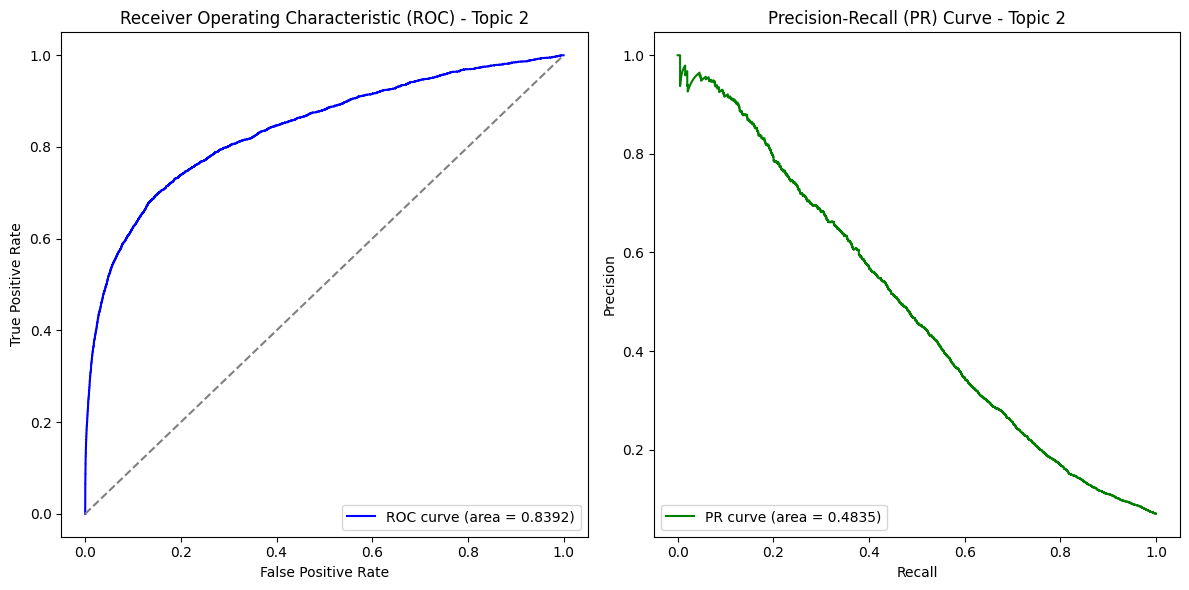

Evaluating topic 3
Topic 3 - auROC: 0.8749, auPR: 0.6819, F1: 0.4655


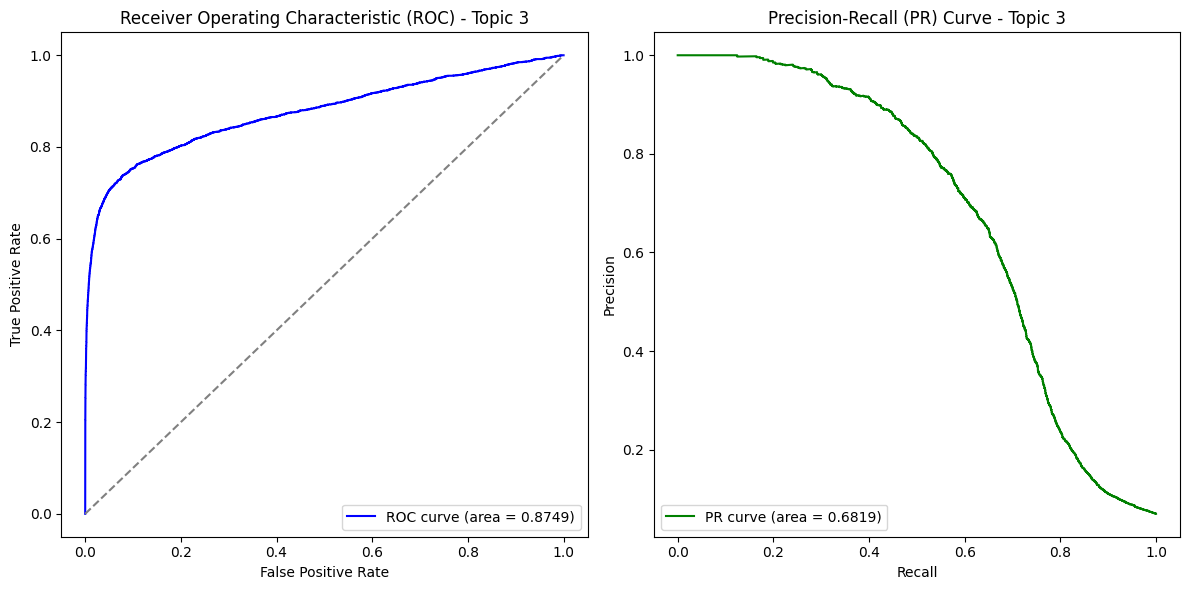

Evaluating topic 4
Topic 4 - auROC: 0.8770, auPR: 0.6370, F1: 0.4715


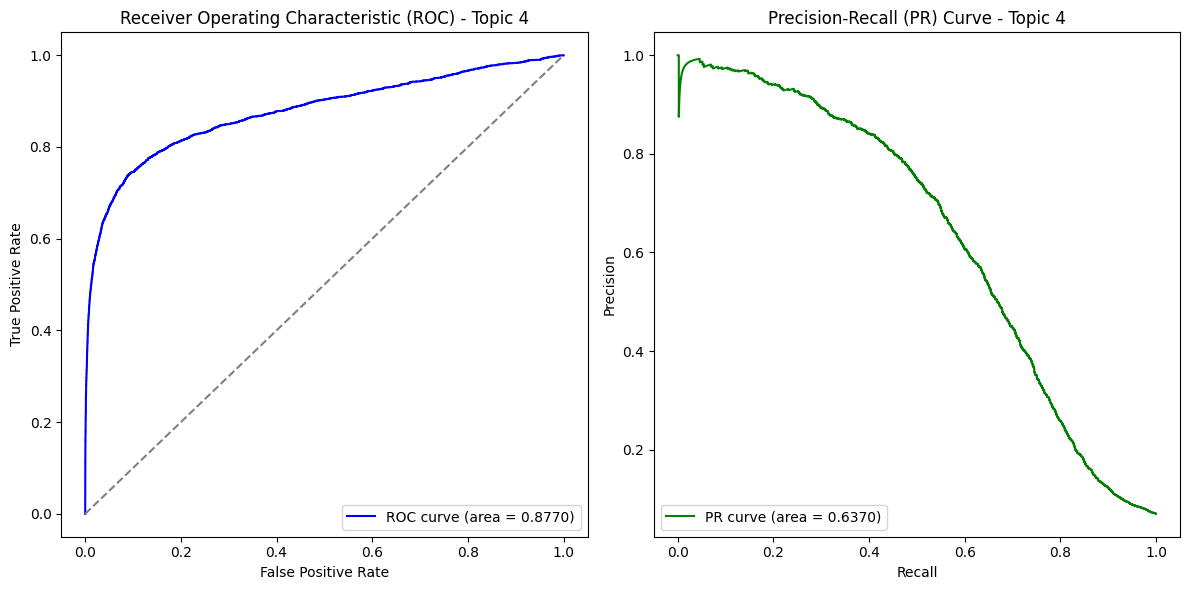

Evaluating topic 5
Topic 5 - auROC: 0.8585, auPR: 0.6201, F1: 0.2347


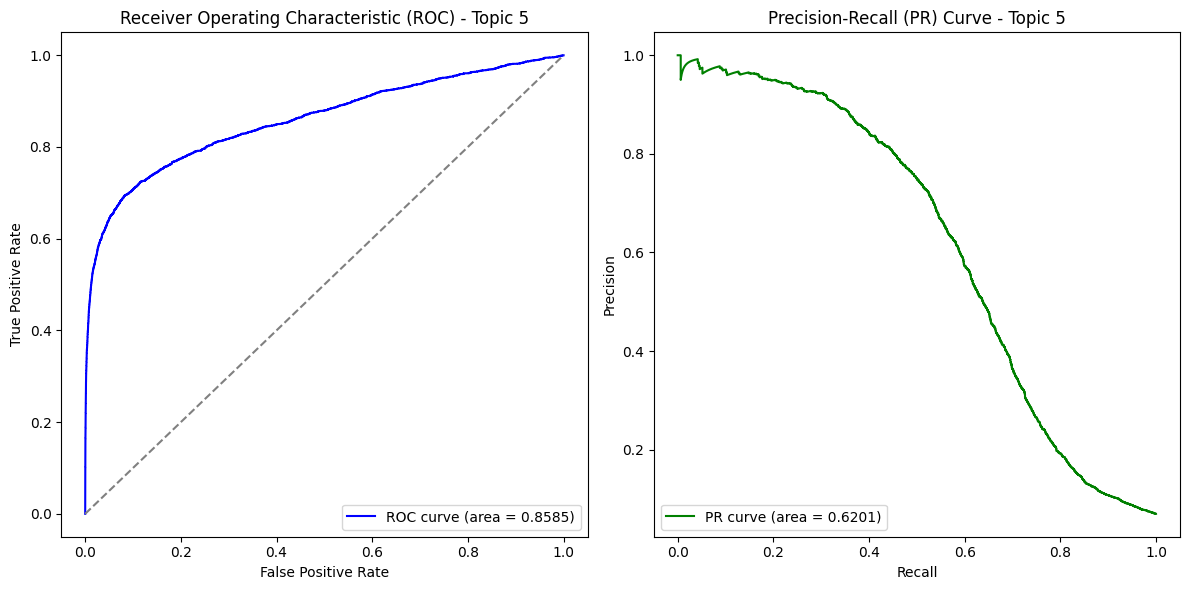

Evaluating topic 6
Topic 6 - auROC: 0.8720, auPR: 0.6038, F1: 0.4347


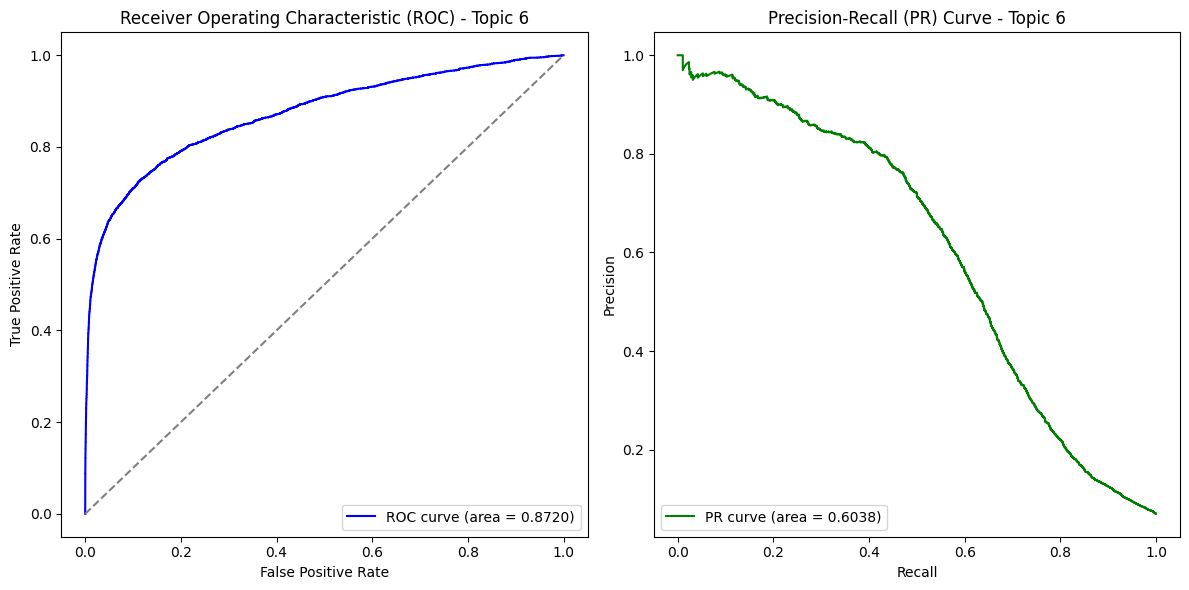

Evaluating topic 7
Topic 7 - auROC: 0.8481, auPR: 0.5167, F1: 0.1987


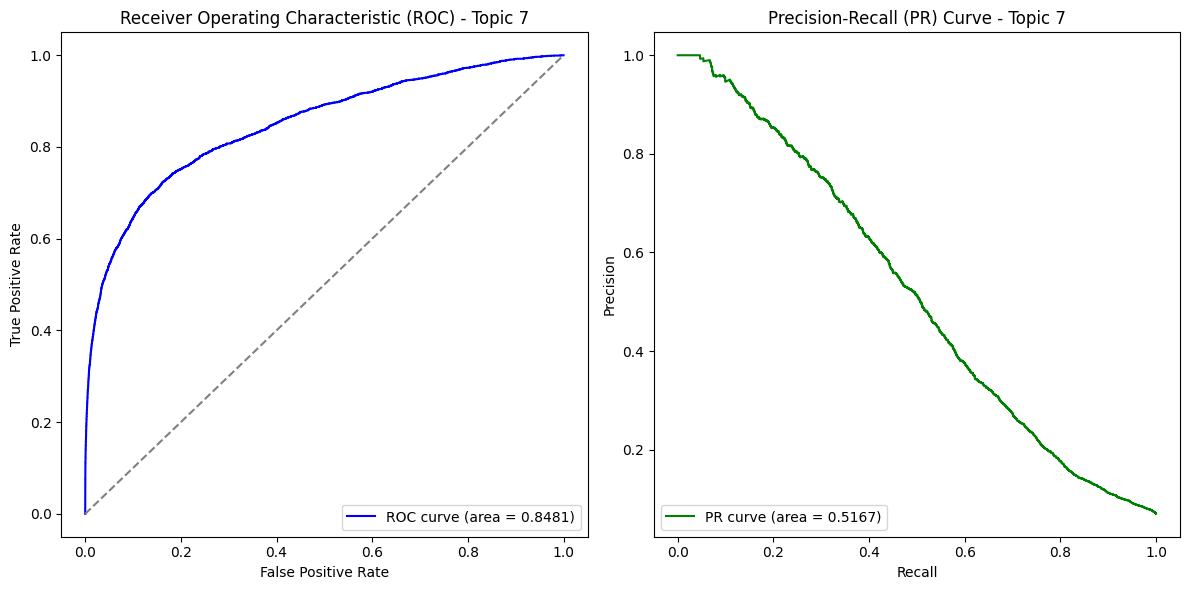

Evaluating topic 8
Topic 8 - auROC: 0.8521, auPR: 0.5213, F1: 0.1368


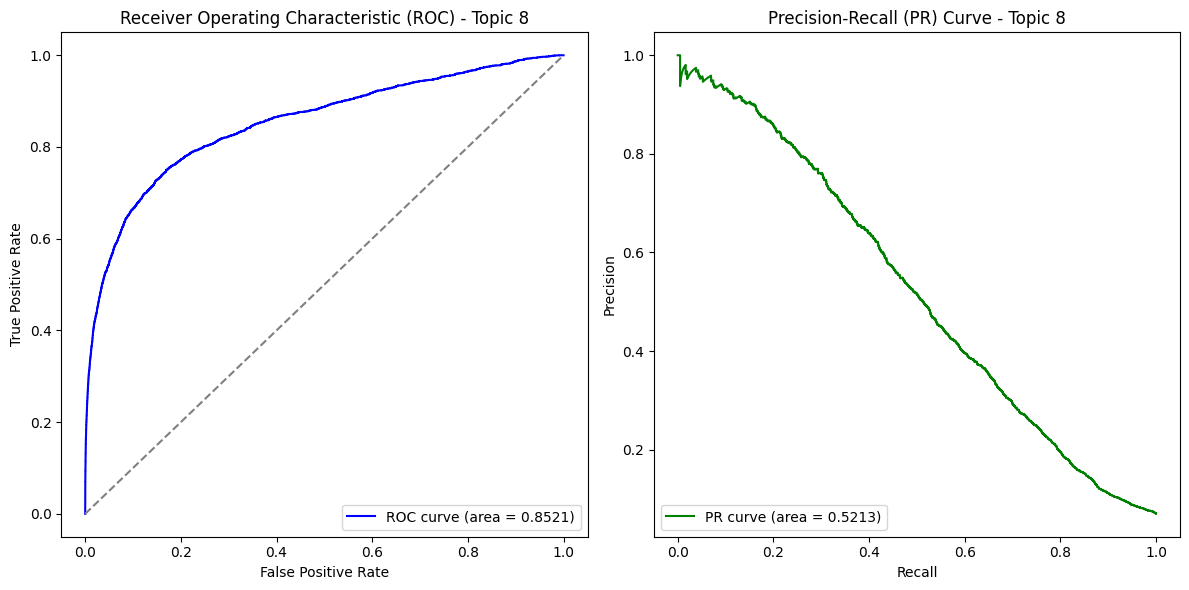

Evaluating topic 9
Topic 9 - auROC: 0.8496, auPR: 0.5532, F1: 0.2401


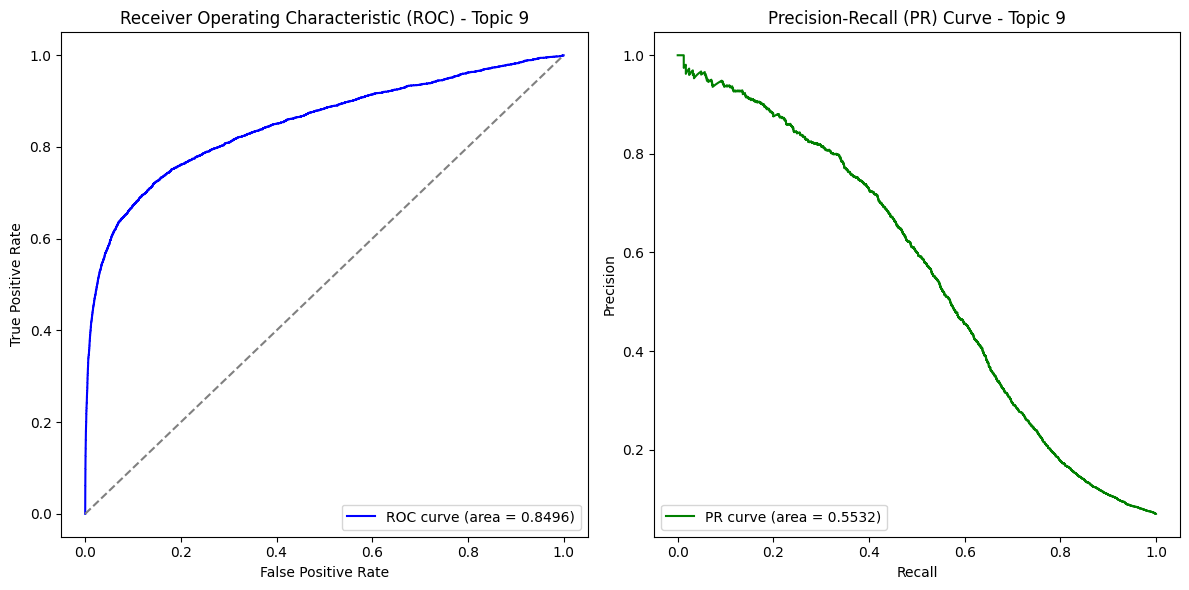

Evaluating topic 10
Topic 10 - auROC: 0.8783, auPR: 0.6064, F1: 0.3264


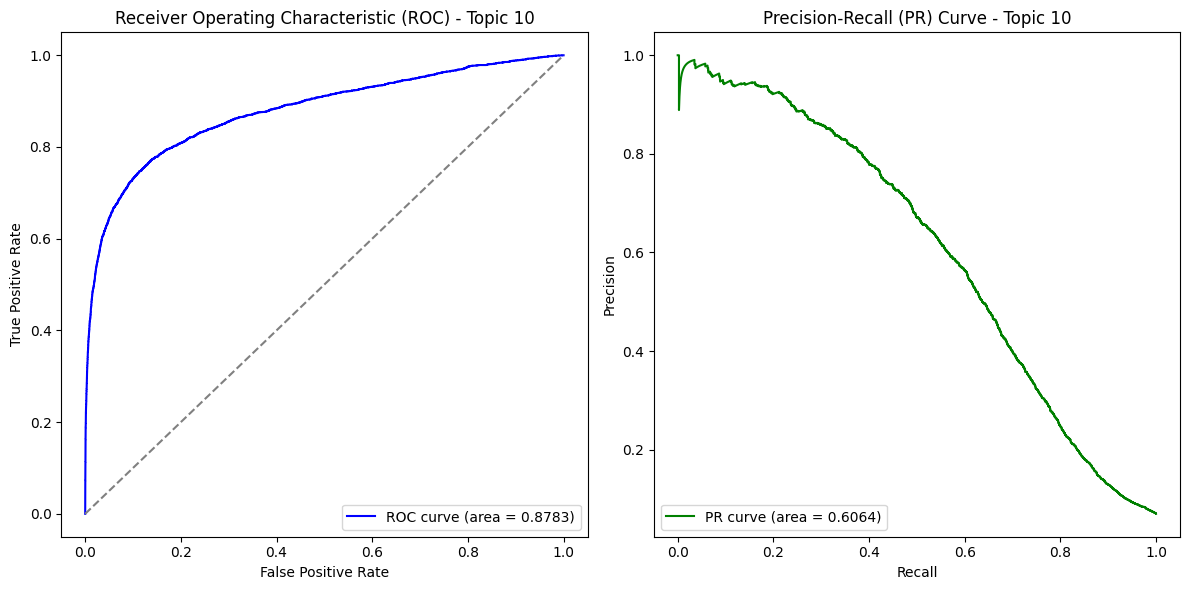

Evaluating topic 11
Topic 11 - auROC: 0.8606, auPR: 0.5824, F1: 0.3334


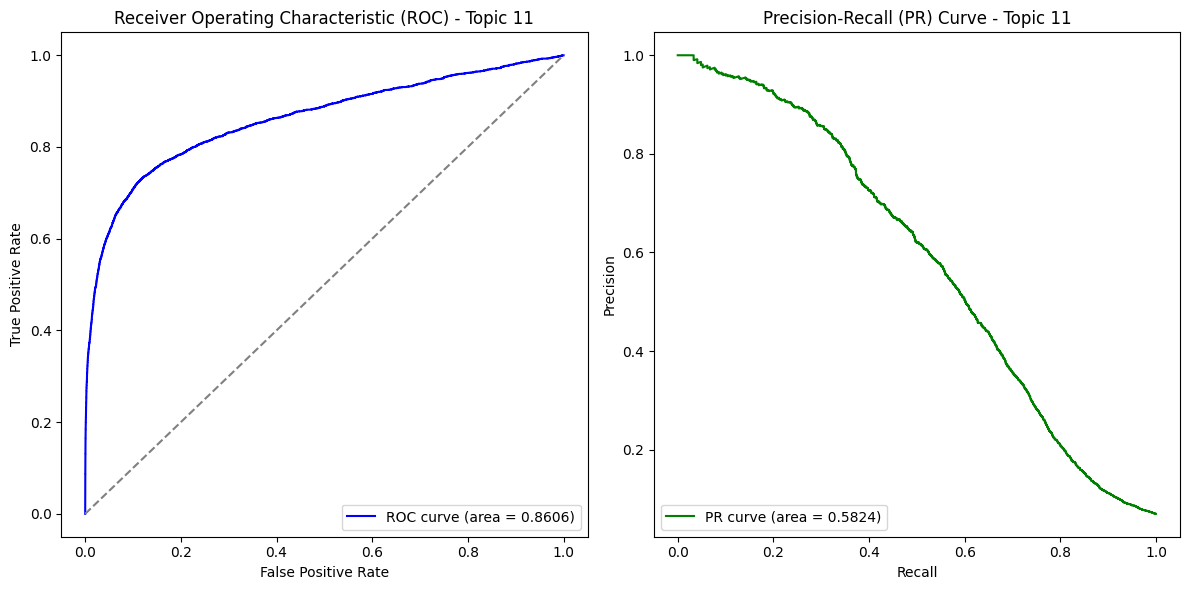

Evaluating topic 12
Topic 12 - auROC: 0.8383, auPR: 0.5127, F1: 0.0532


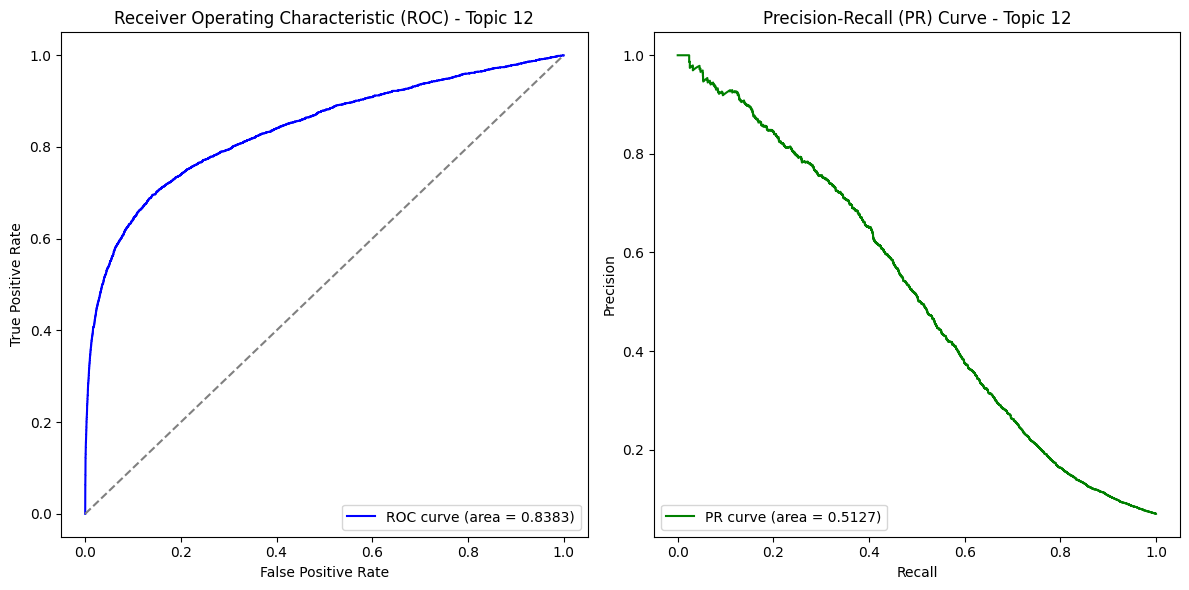

Evaluating topic 13
Topic 13 - auROC: 0.8803, auPR: 0.6276, F1: 0.5380


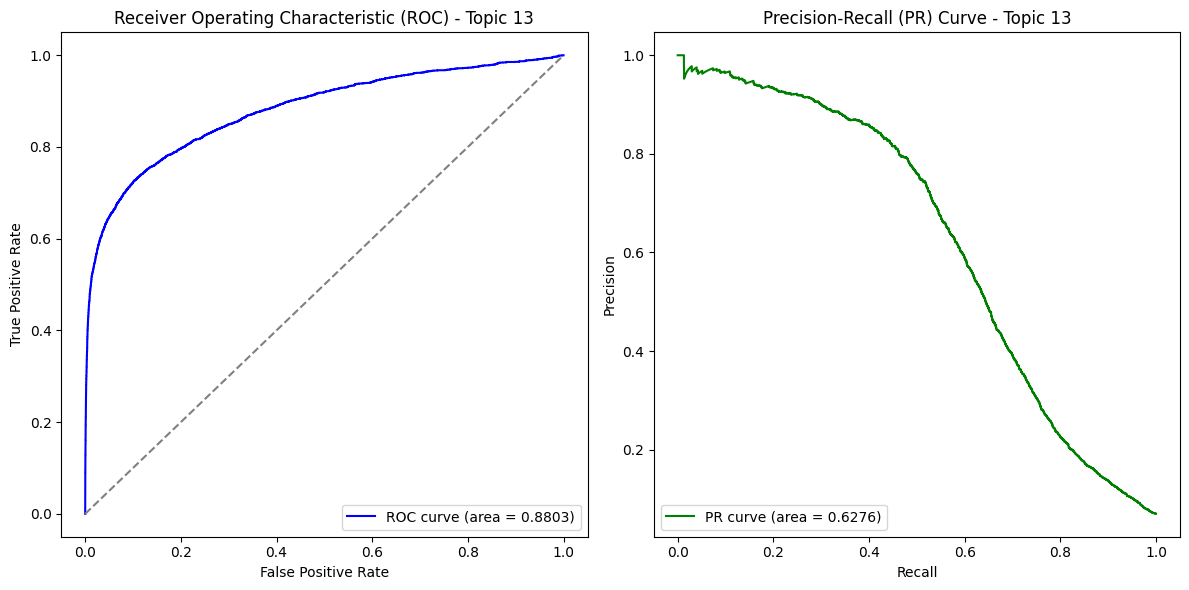

Evaluating topic 14
Topic 14 - auROC: 0.8541, auPR: 0.5267, F1: 0.2024


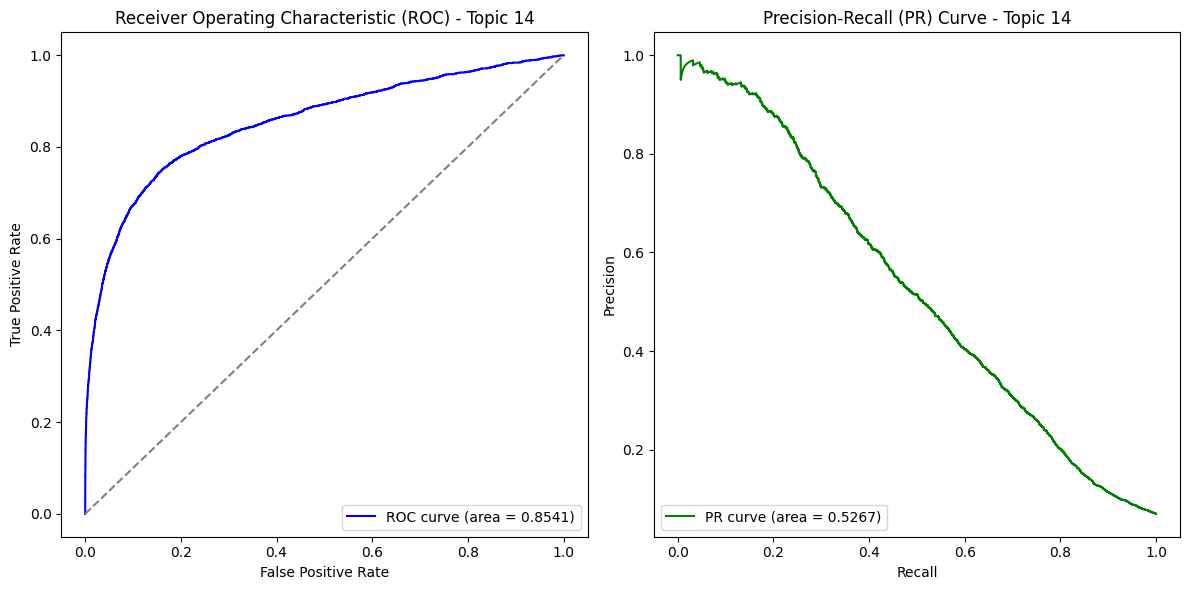

Evaluating topic 15
Topic 15 - auROC: 0.8464, auPR: 0.5377, F1: 0.1465


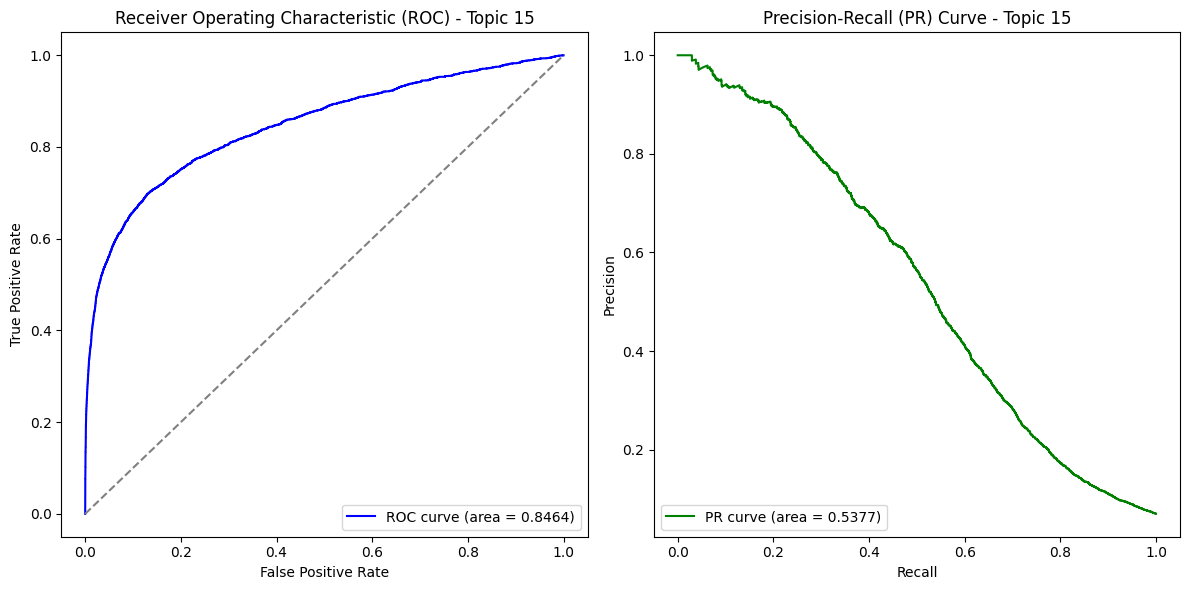

Evaluating topic 16
Topic 16 - auROC: 0.8775, auPR: 0.6432, F1: 0.3433


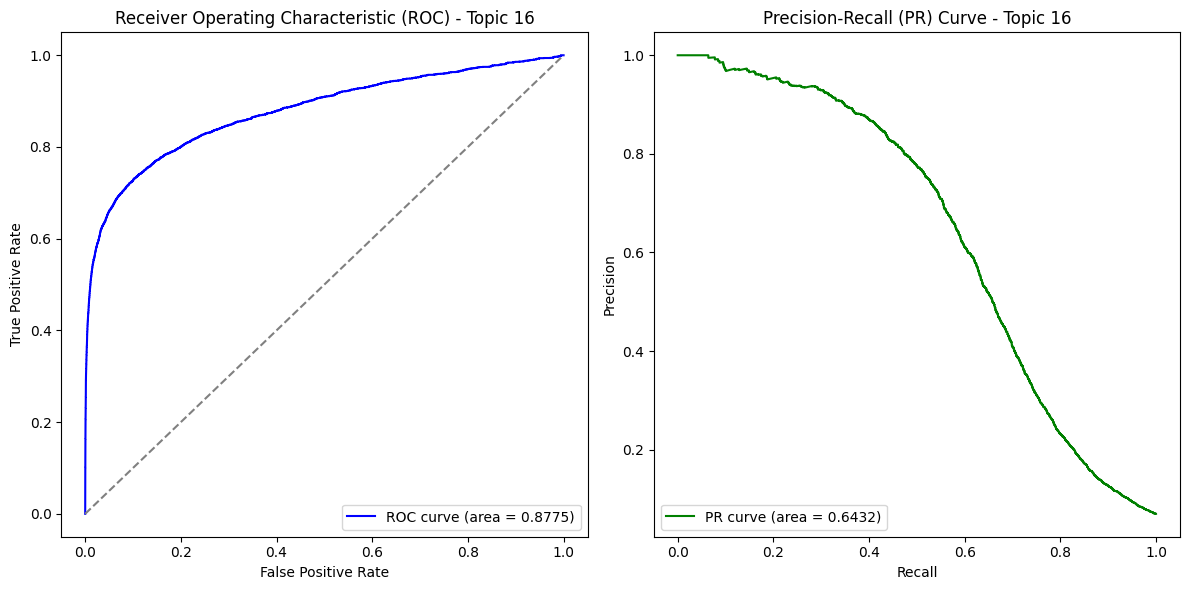

Evaluating topic 17
Topic 17 - auROC: 0.8476, auPR: 0.5188, F1: 0.1106


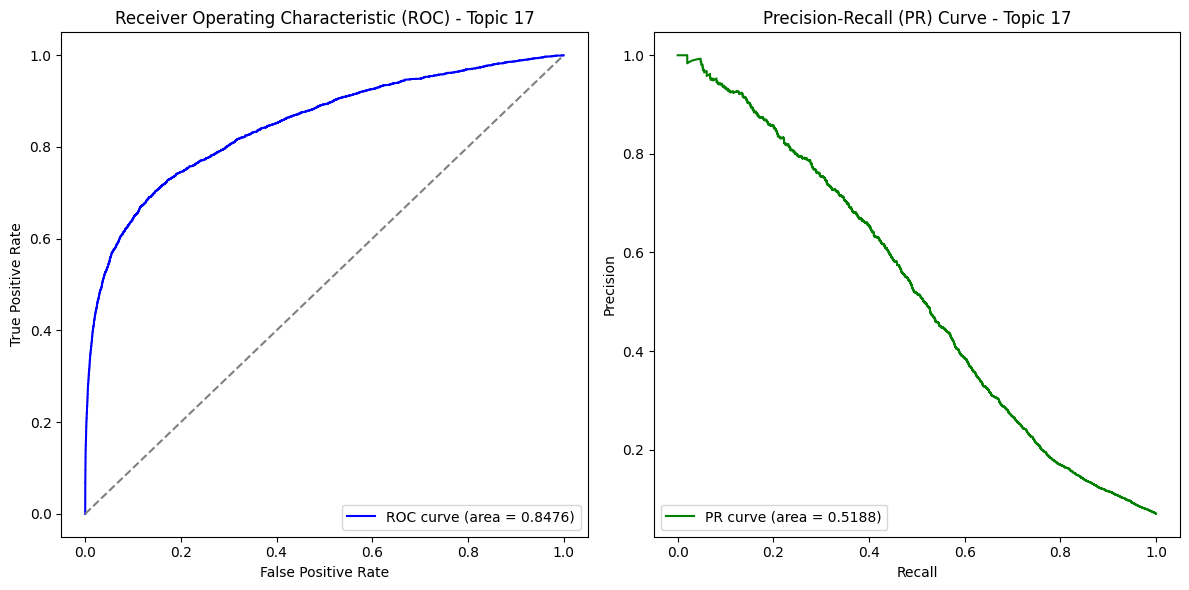

In [17]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [18]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.8627 ± 0.0167
Mean auPR: 0.5829 ± 0.0679
Mean F1: 0.2974 ± 0.1650
Exact Match Accuracy: 0.1718
Hamming Accuracy: 0.9421


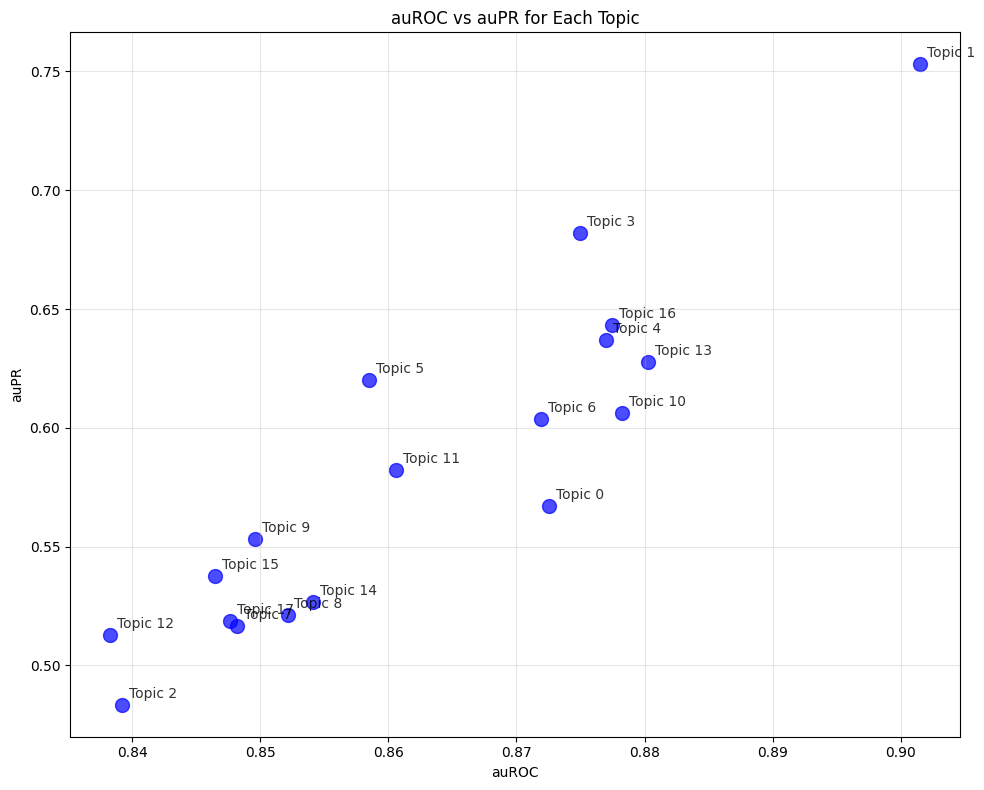

In [19]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

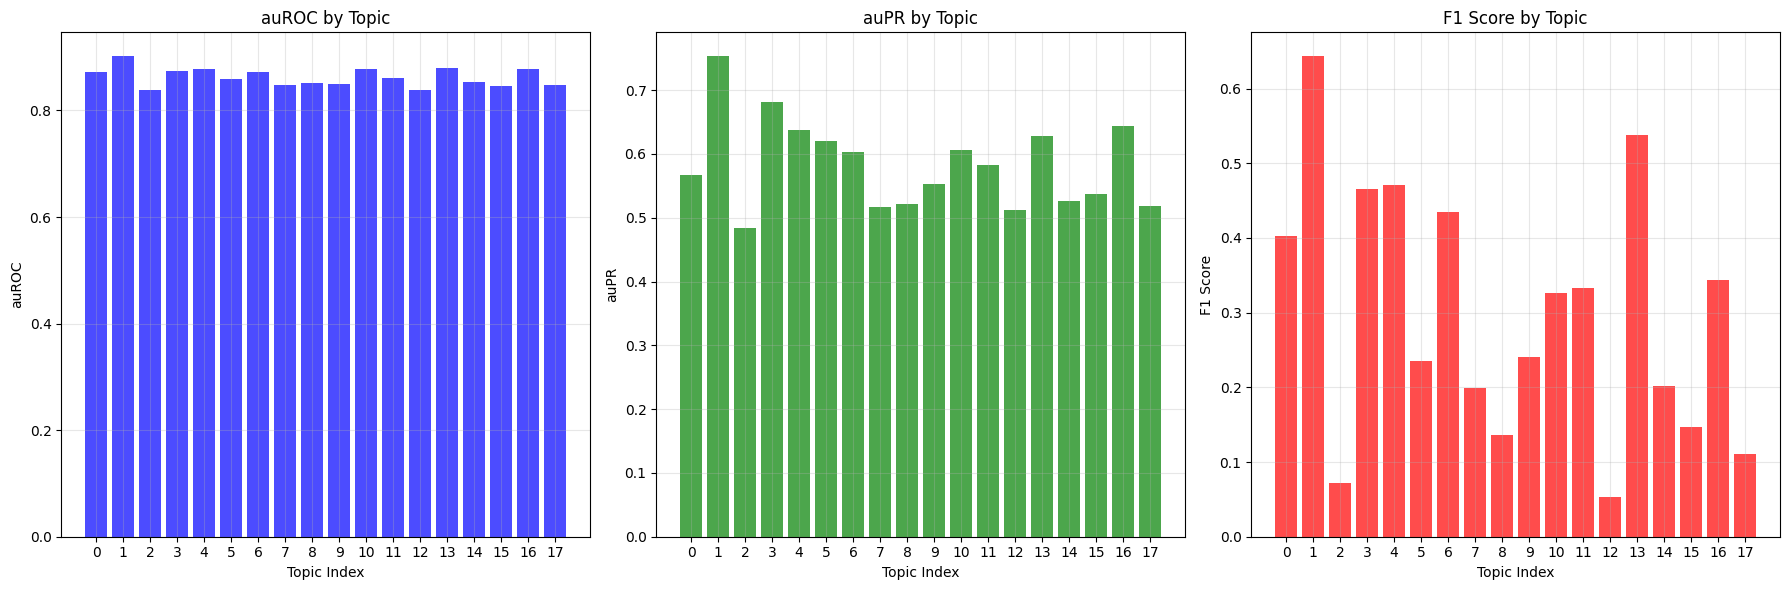

In [20]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

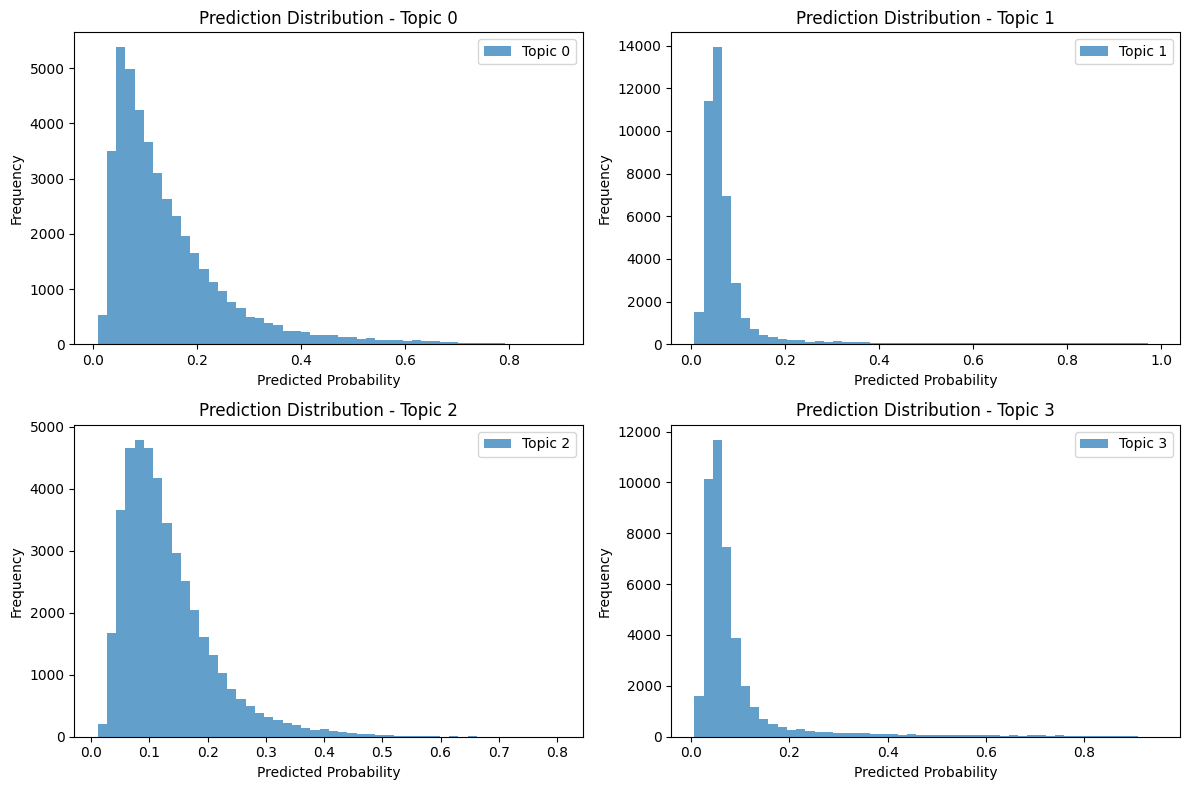


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.04276229 0.0446423  0.20845583 0.07309636 0.04971694 0.12422436
 0.0596135  0.04023938 0.05262005 0.24655993 0.04735003 0.13204838
 0.12305482 0.04028412 0.04431965 0.1361411  0.14543022 0.1595322 ]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.07731876 0.0646885  0.06504732 0.1494762  0.04137436 0.35811222
 0.13081278 0.08202398 0.14051893 0.06350587 0.04929437 0.05405254
 0.11044691 0.07002717 0.1732035  0.12371602 0.02875569 0.19148067]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.2990282  0.04037997 0.07280716 0.04223818 0.17438322 0.03155259
 0.13869487 0.09275344 0.1035203  0.04953859 0.13140617 0.1358051
 0.04385692 0.36802608 0.07965817 0.07267555 0.07901922 0.0783096 ]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [21]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [22]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [23]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 0.006943105 0.92765194
Prediction shape: (6430, 18)
Target shape: (6430, 18)


In [24]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0684
Topic 1: 0.0661
Topic 2: 0.0725
Topic 3: 0.0734
Topic 4: 0.0712
Topic 5: 0.0664
Topic 6: 0.0708
Topic 7: 0.0703
Topic 8: 0.0666
Topic 9: 0.0712
Topic 10: 0.0659
Topic 11: 0.0726
Topic 12: 0.0669
Topic 13: 0.0750
Topic 14: 0.0692
Topic 15: 0.0706
Topic 16: 0.0691
Topic 17: 0.0734


In [25]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[5938   52]
 [ 431    9]]

Topic 1:
[[5967   38]
 [ 415   10]]

Topic 2:
[[5962    2]
 [ 466    0]]

Topic 3:
[[5950    8]
 [ 469    3]]

Topic 4:
[[5912   60]
 [ 442   16]]

Topic 5:
[[5994    9]
 [ 427    0]]

Topic 6:
[[5910   65]
 [ 451    4]]

Topic 7:
[[5973    5]
 [ 451    1]]

Topic 8:
[[5998    4]
 [ 426    2]]

Topic 9:
[[5959   13]
 [ 455    3]]

Topic 10:
[[5987   19]
 [ 420    4]]

Topic 11:
[[5943   20]
 [ 463    4]]

Topic 12:
[[5999    1]
 [ 430    0]]

Topic 13:
[[5877   71]
 [ 468   14]]

Topic 14:
[[5979    6]
 [ 442    3]]

Topic 15:
[[5969    7]
 [ 453    1]]

Topic 16:
[[5968   18]
 [ 443    1]]

Topic 17:
[[5954    4]
 [ 472    0]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.6068, auPR: 0.0916, F1: 0.0359


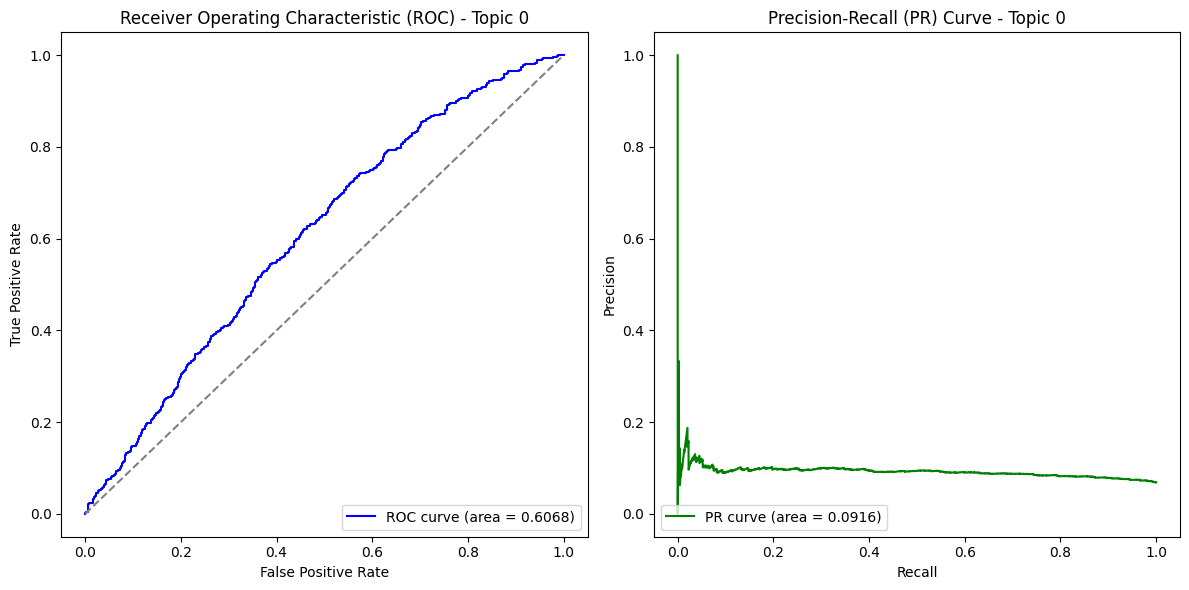

Evaluating topic 1
Topic 1 - auROC: 0.6217, auPR: 0.1210, F1: 0.0423


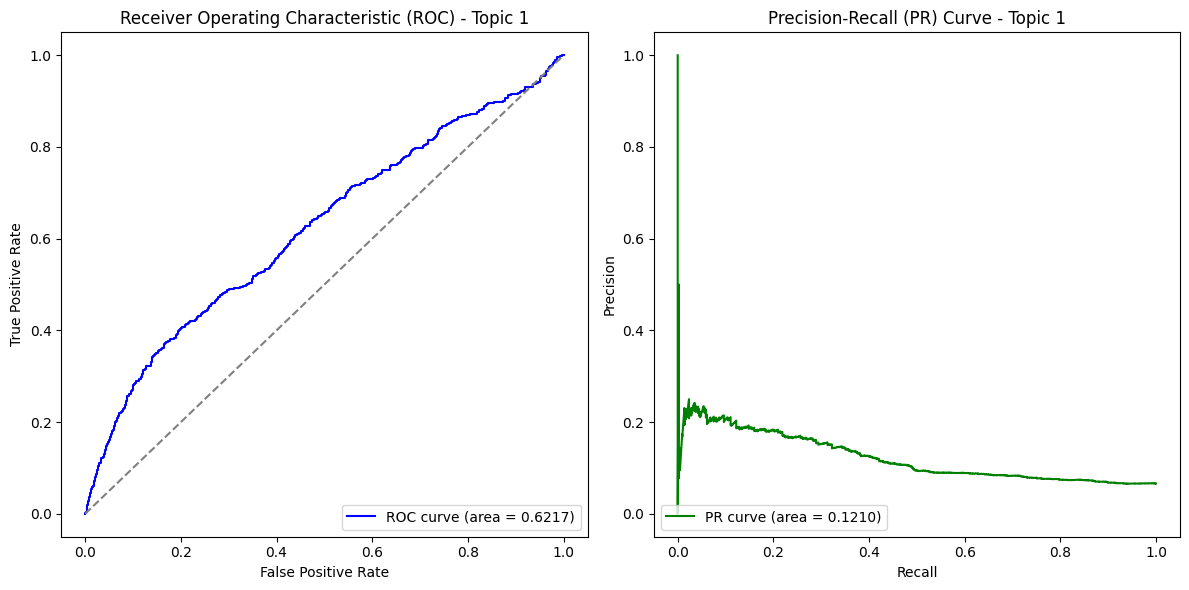

Evaluating topic 2
Topic 2 - auROC: 0.5594, auPR: 0.0828, F1: 0.0000


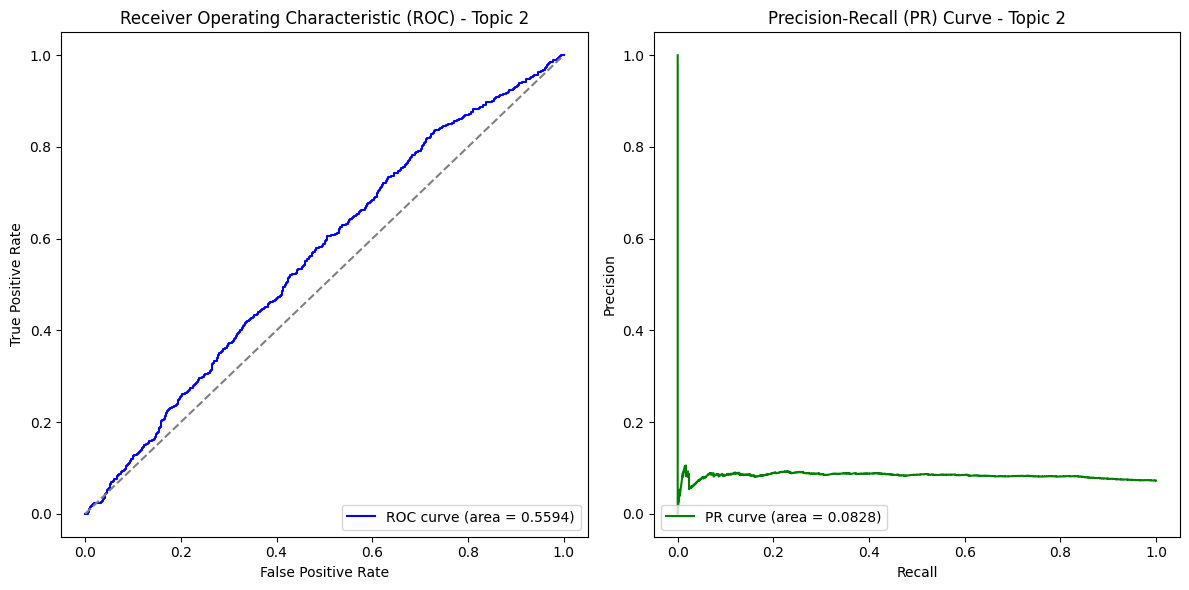

Evaluating topic 3
Topic 3 - auROC: 0.5619, auPR: 0.1075, F1: 0.0124


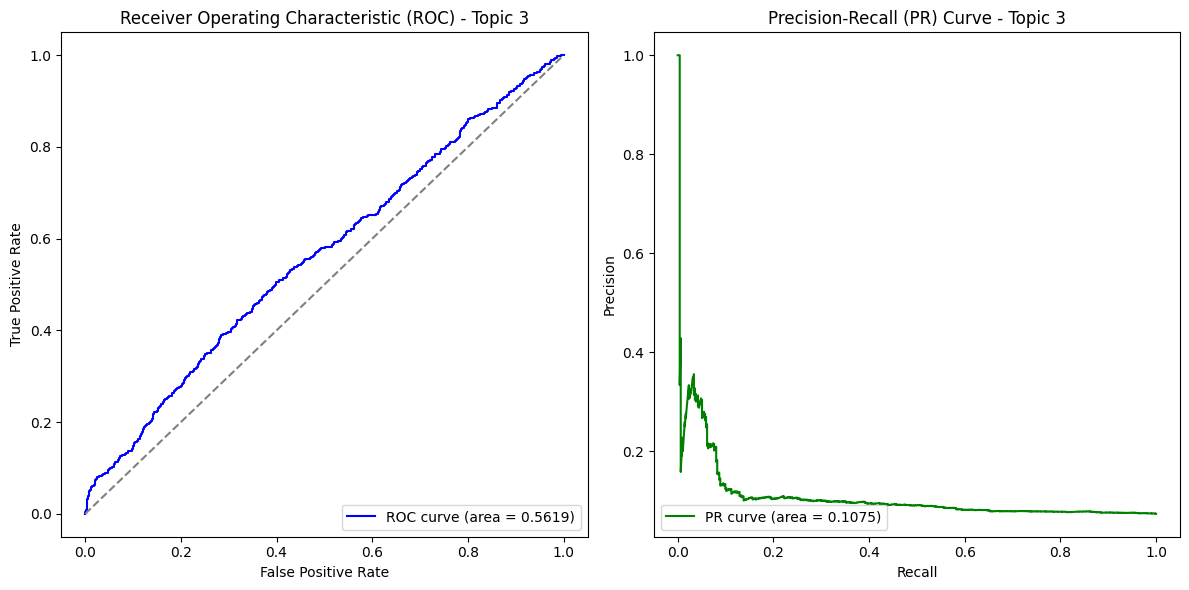

Evaluating topic 4
Topic 4 - auROC: 0.5884, auPR: 0.1193, F1: 0.0599


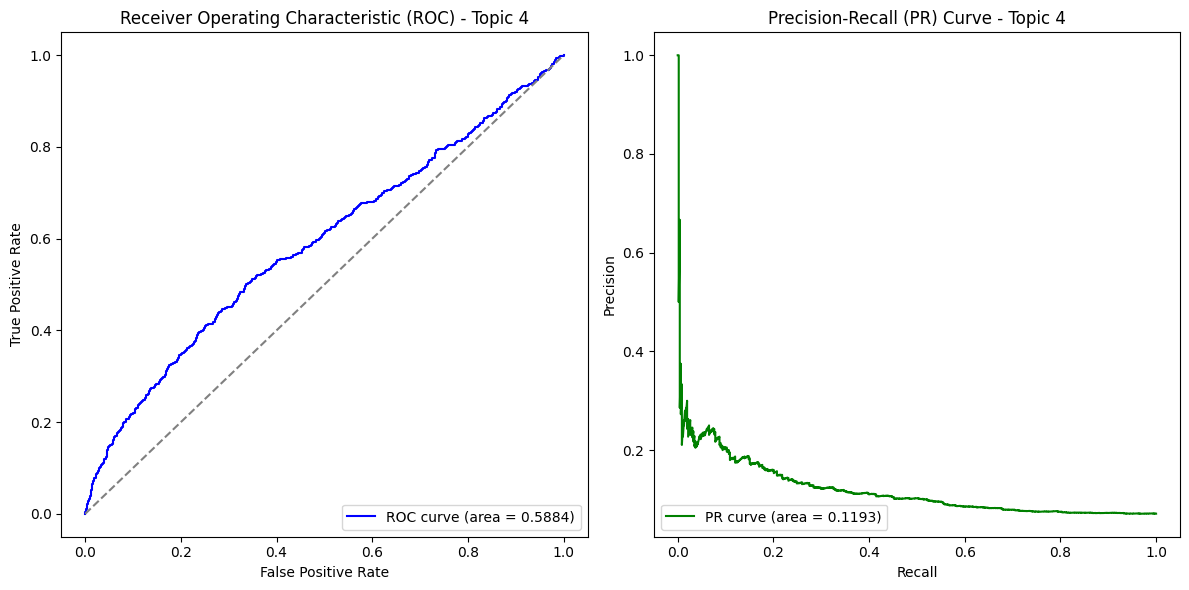

Evaluating topic 5
Topic 5 - auROC: 0.5263, auPR: 0.0736, F1: 0.0000


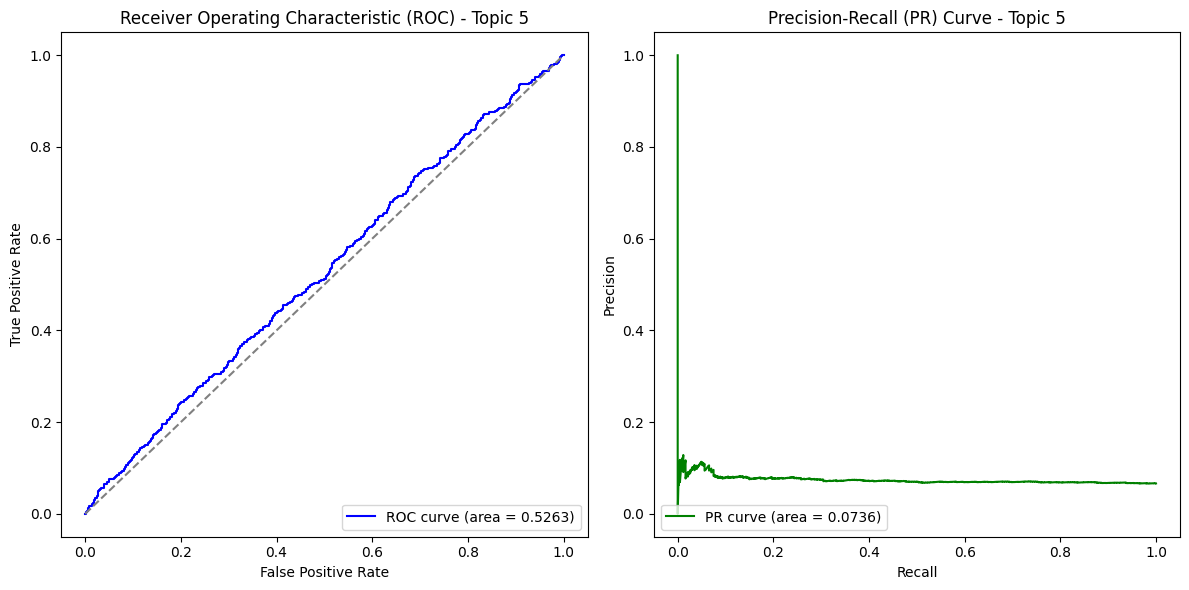

Evaluating topic 6
Topic 6 - auROC: 0.5880, auPR: 0.0886, F1: 0.0153


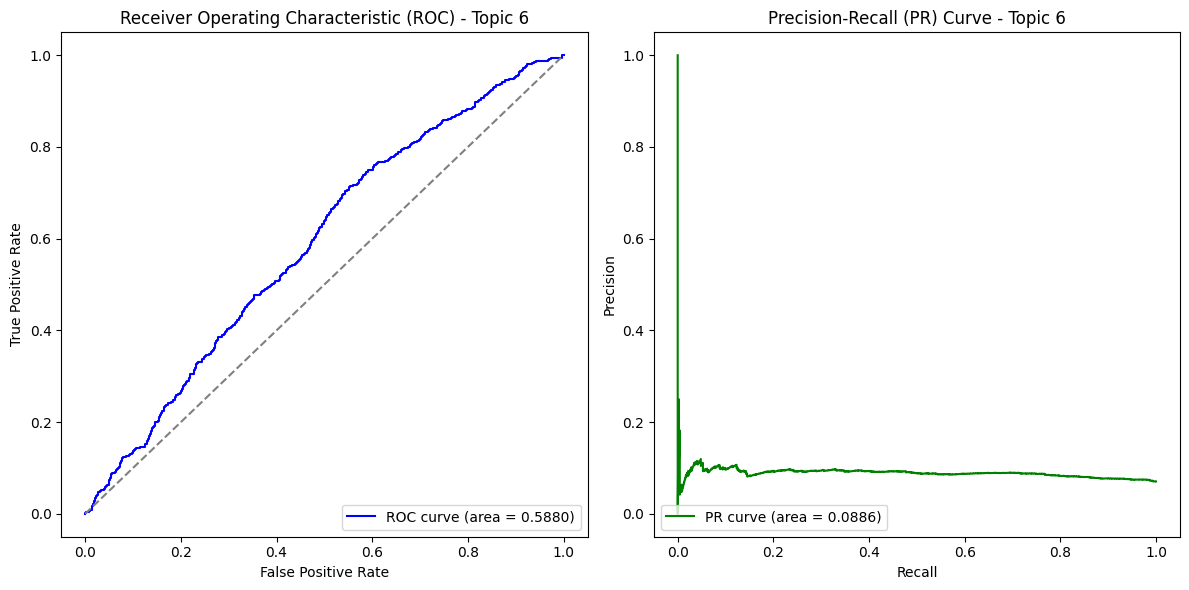

Evaluating topic 7
Topic 7 - auROC: 0.5798, auPR: 0.0918, F1: 0.0044


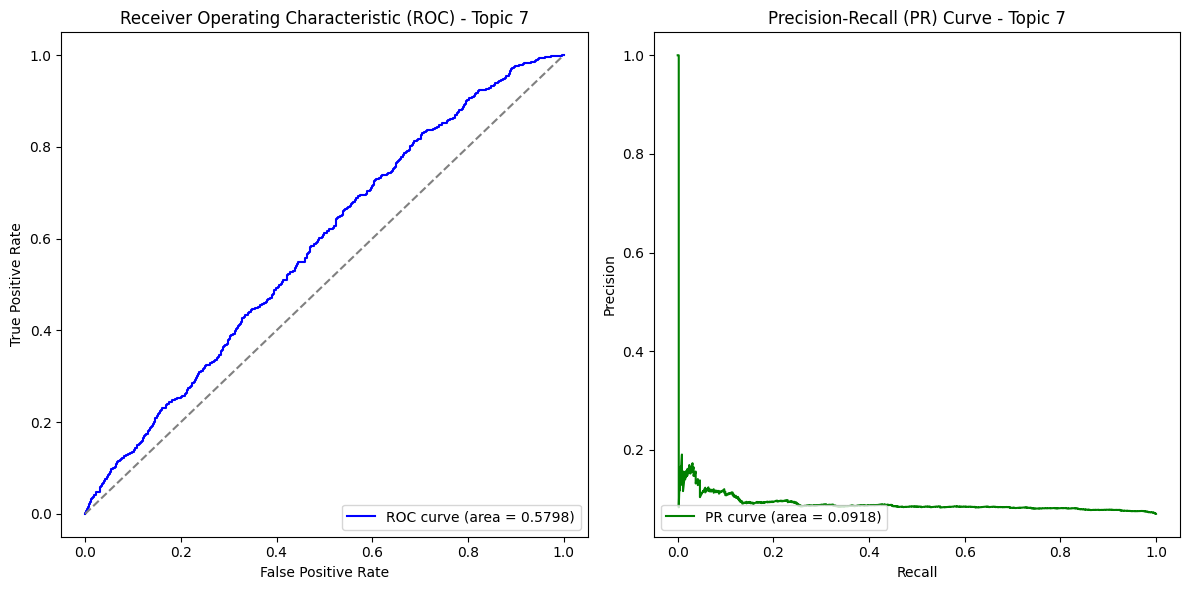

Evaluating topic 8
Topic 8 - auROC: 0.5777, auPR: 0.0989, F1: 0.0092


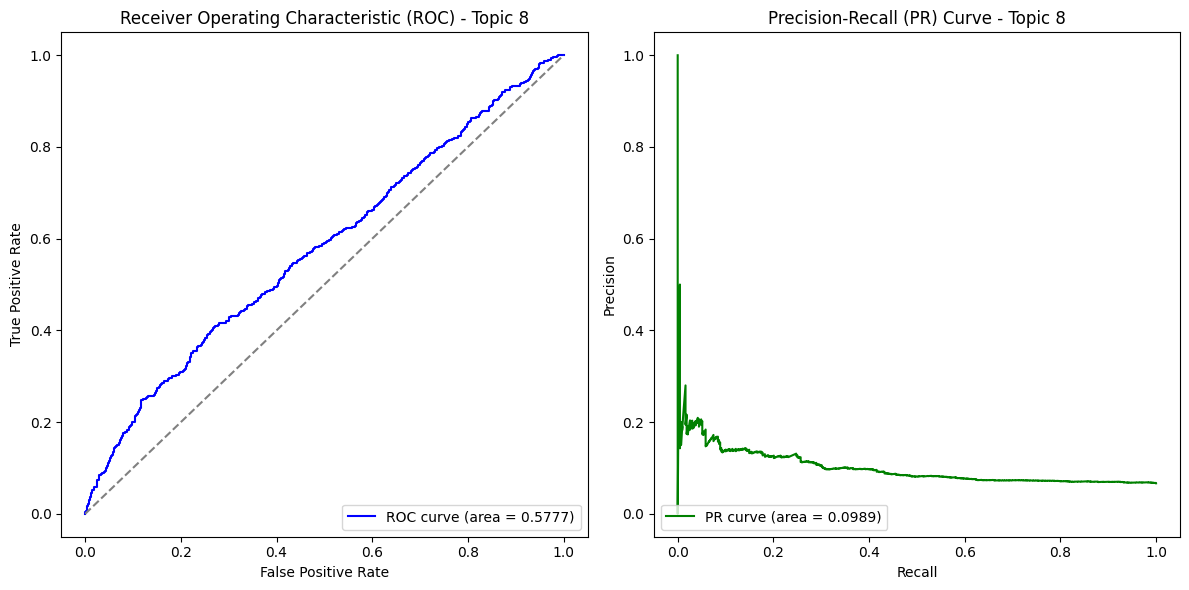

Evaluating topic 9
Topic 9 - auROC: 0.5332, auPR: 0.0798, F1: 0.0127


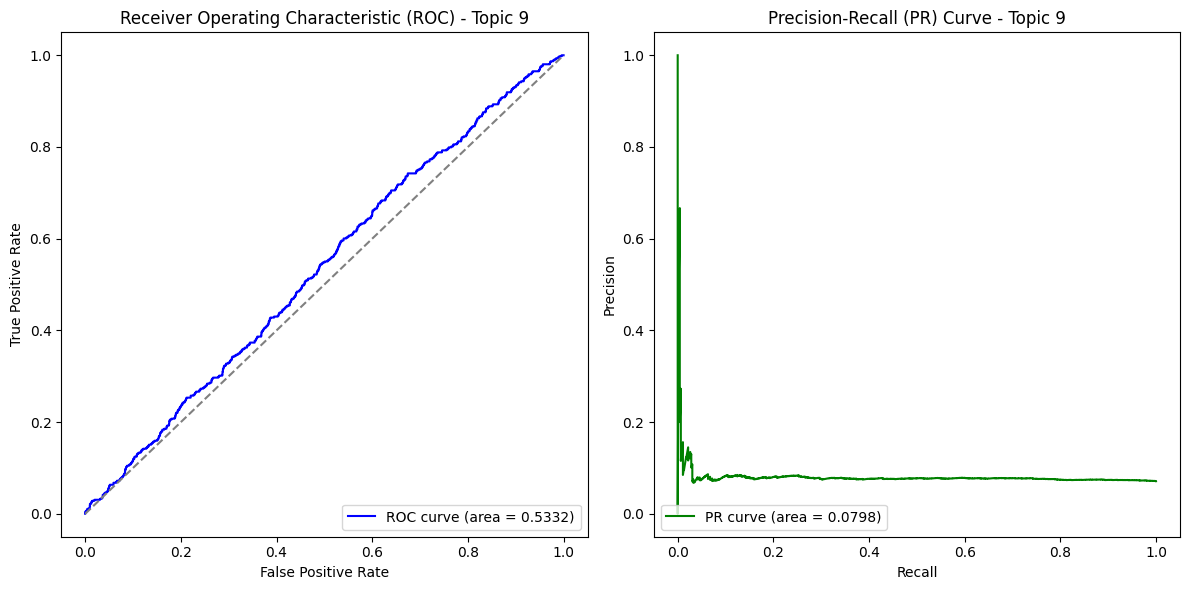

Evaluating topic 10
Topic 10 - auROC: 0.6151, auPR: 0.1070, F1: 0.0179


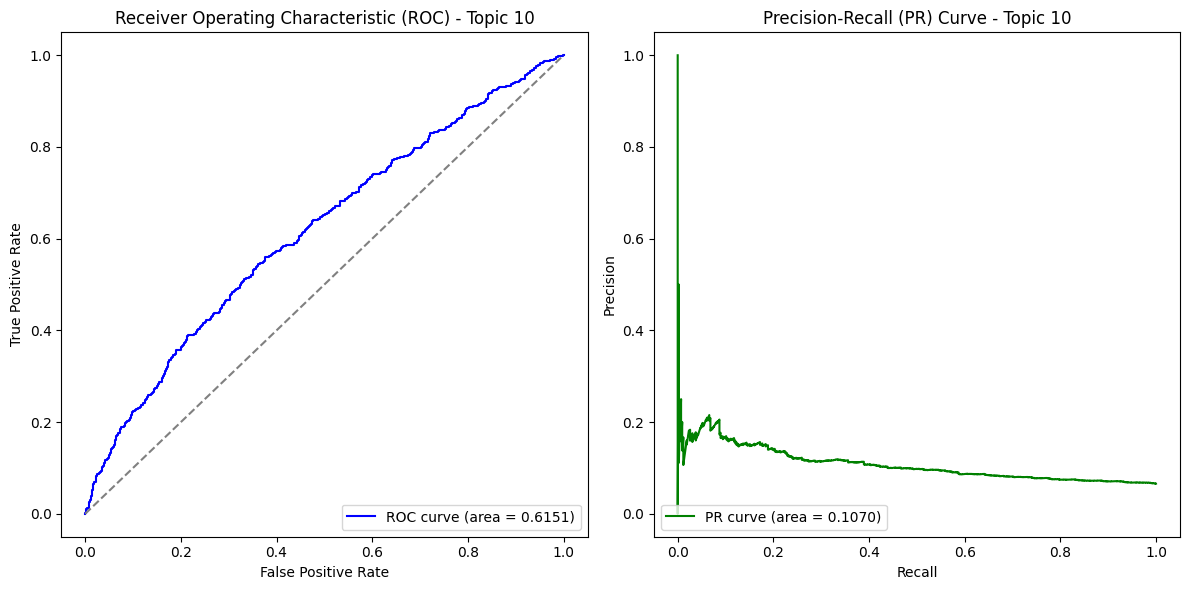

Evaluating topic 11
Topic 11 - auROC: 0.5689, auPR: 0.1024, F1: 0.0163


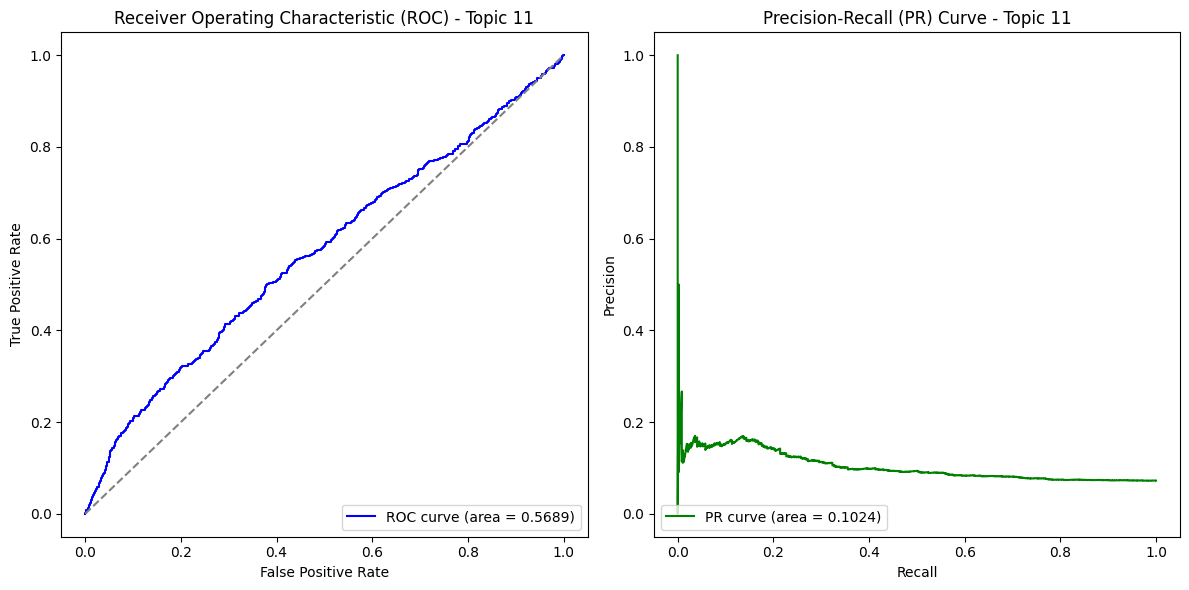

Evaluating topic 12
Topic 12 - auROC: 0.5218, auPR: 0.0700, F1: 0.0000


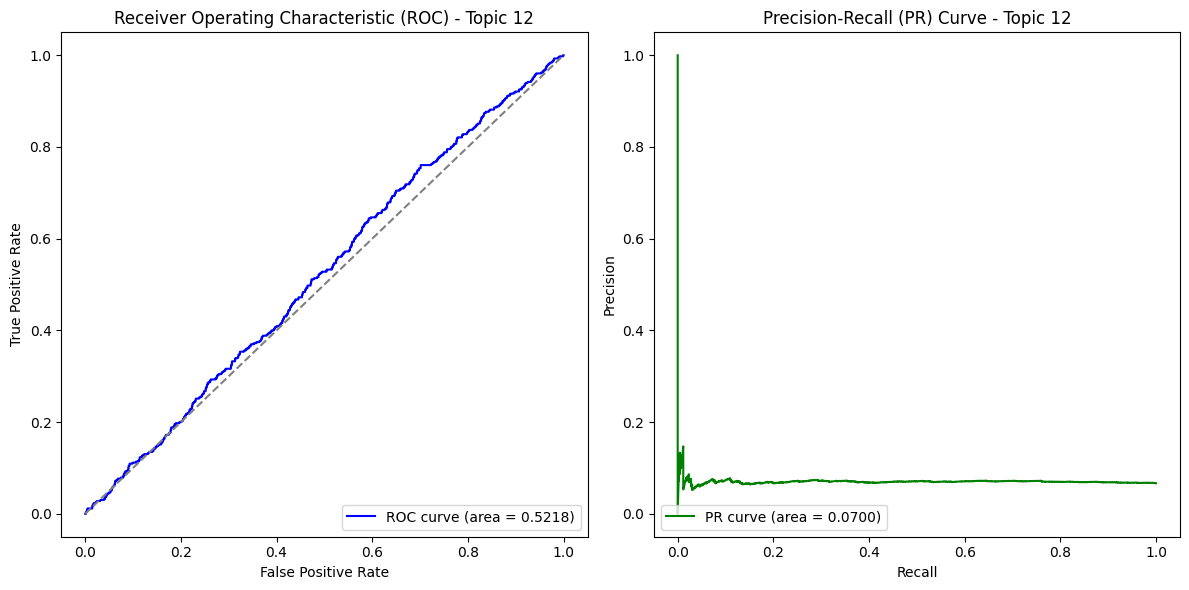

Evaluating topic 13
Topic 13 - auROC: 0.6204, auPR: 0.1090, F1: 0.0494


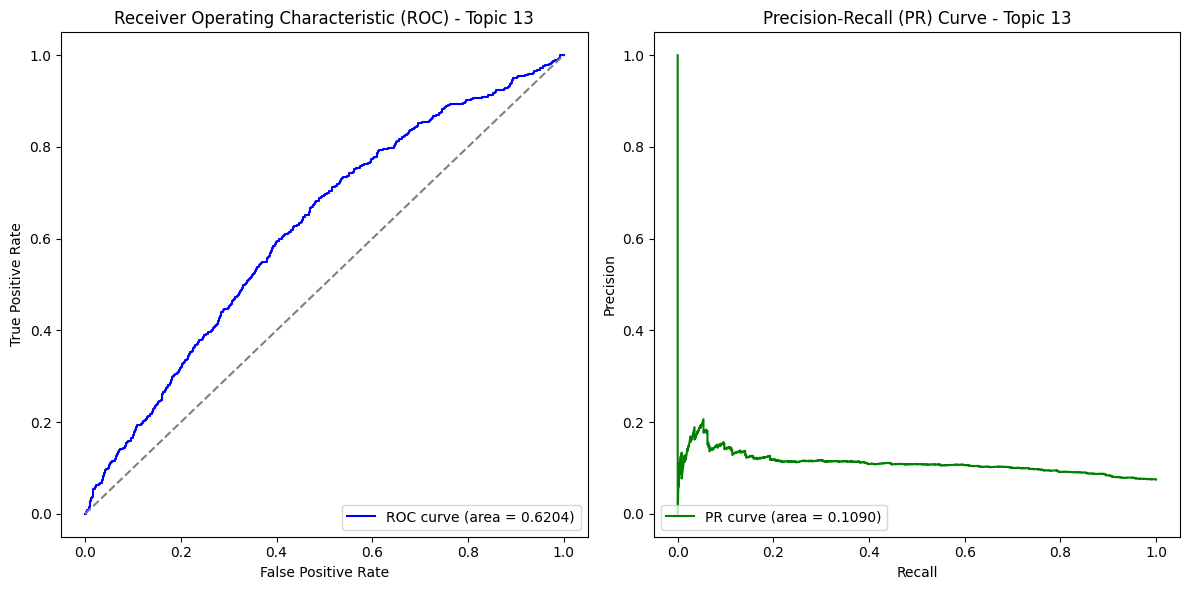

Evaluating topic 14
Topic 14 - auROC: 0.5922, auPR: 0.1000, F1: 0.0132


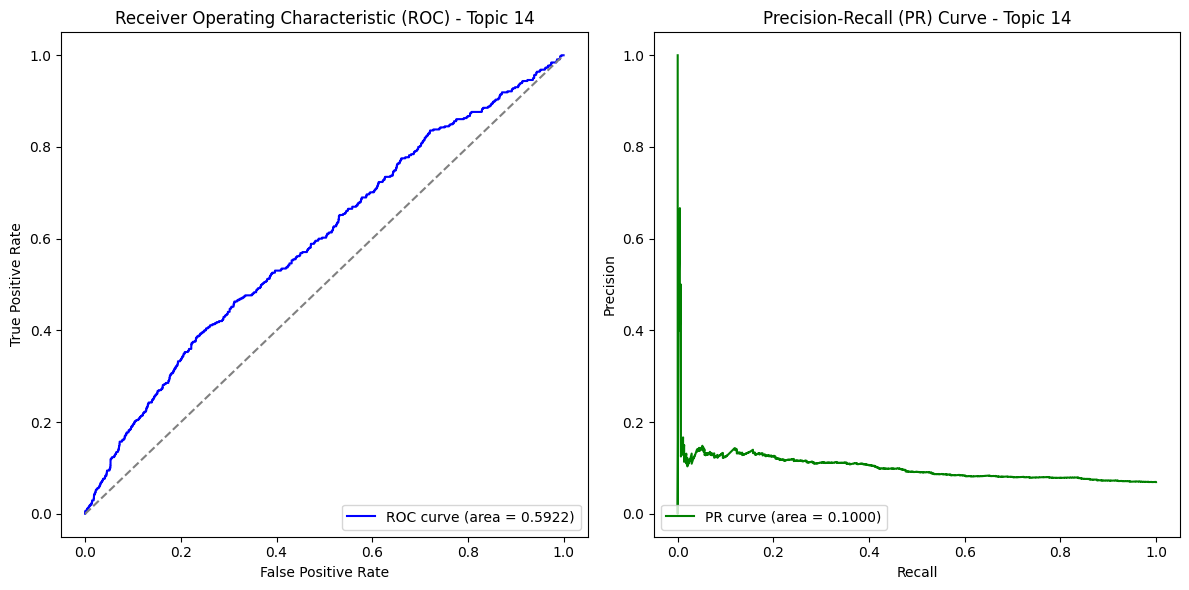

Evaluating topic 15
Topic 15 - auROC: 0.5142, auPR: 0.0727, F1: 0.0043


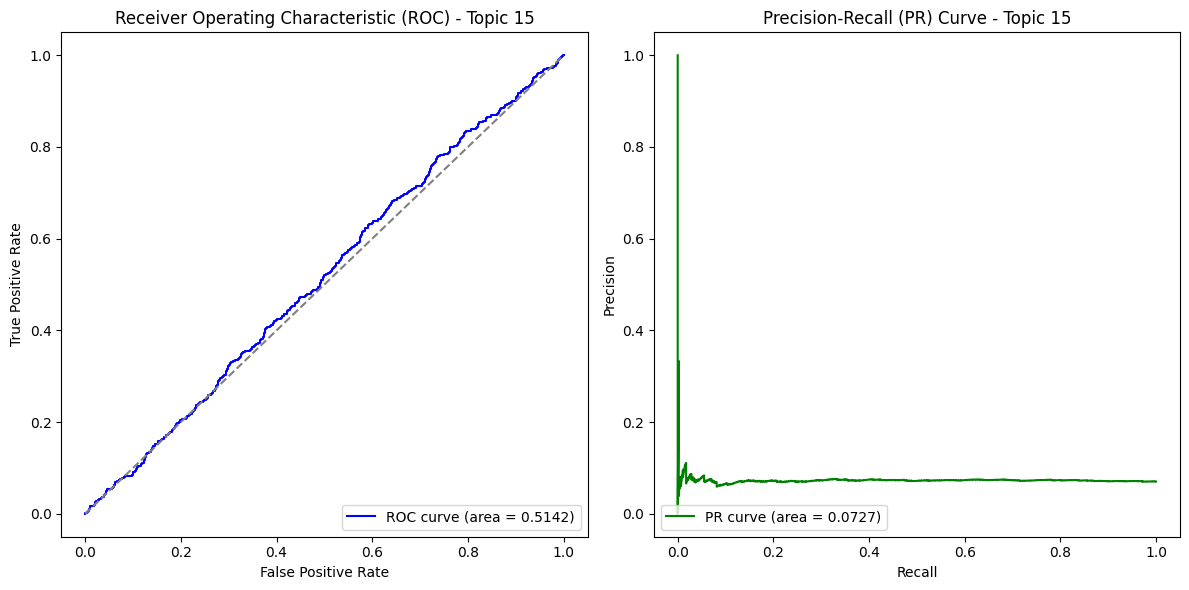

Evaluating topic 16
Topic 16 - auROC: 0.5964, auPR: 0.1003, F1: 0.0043


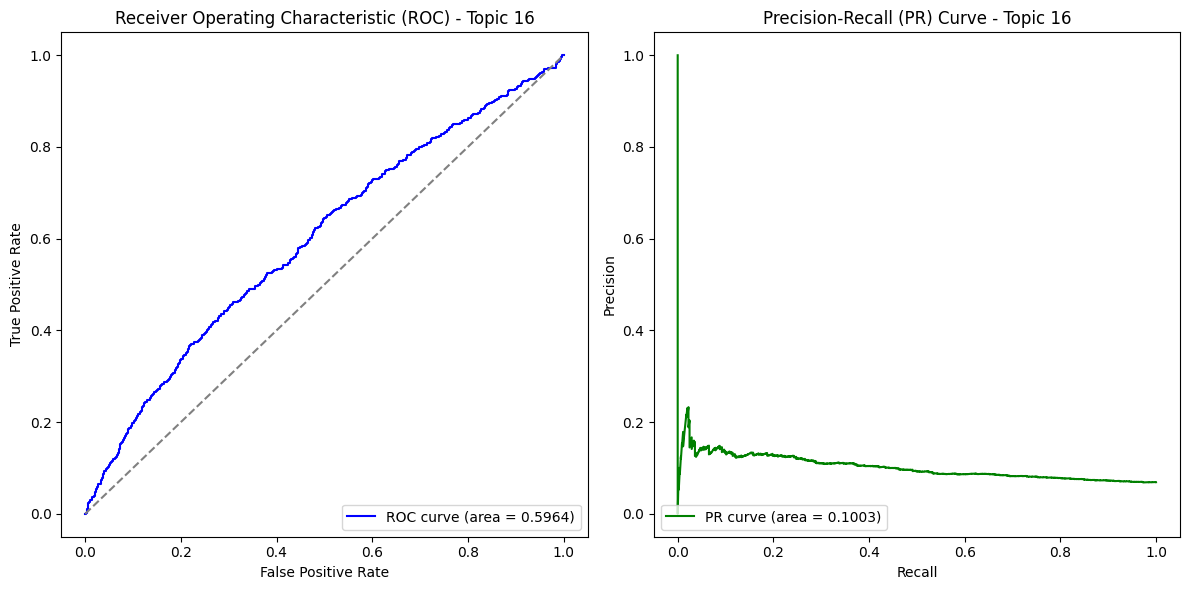

Evaluating topic 17
Topic 17 - auROC: 0.5766, auPR: 0.0870, F1: 0.0000


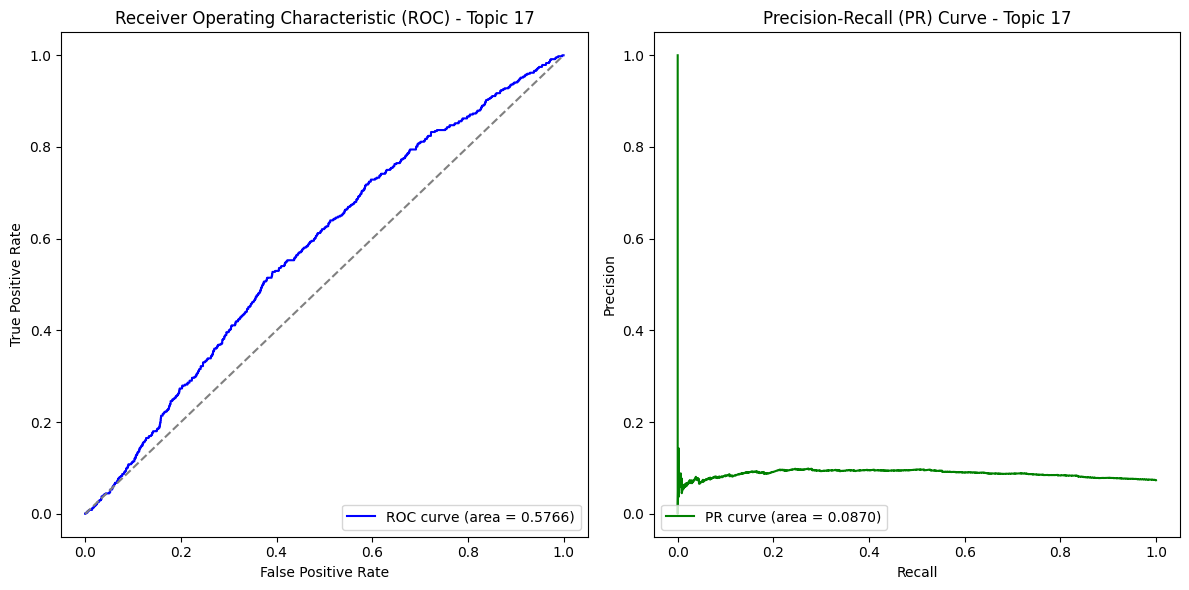

In [26]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [27]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.5749 ± 0.0326
Mean auPR: 0.0946 ± 0.0148
Mean F1: 0.0165 ± 0.0177
Exact Match Accuracy: 0.0010
Hamming Accuracy: 0.9272


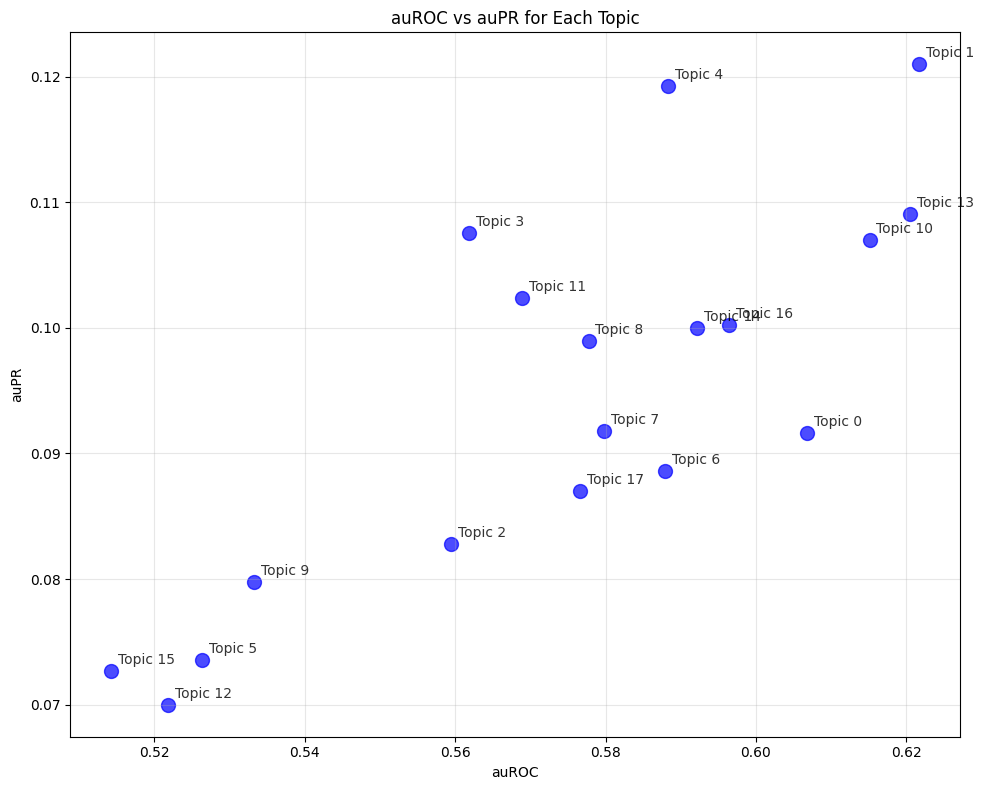

In [28]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

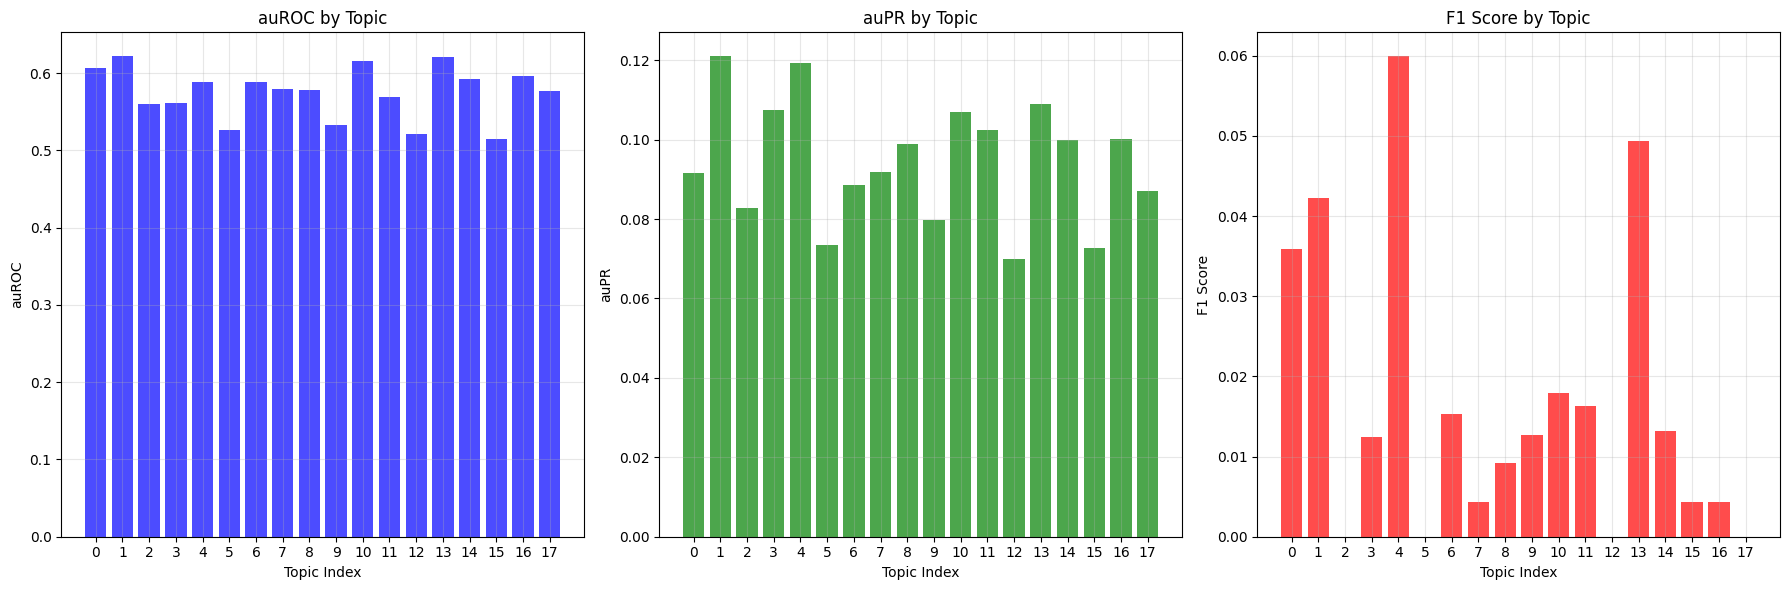

In [29]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

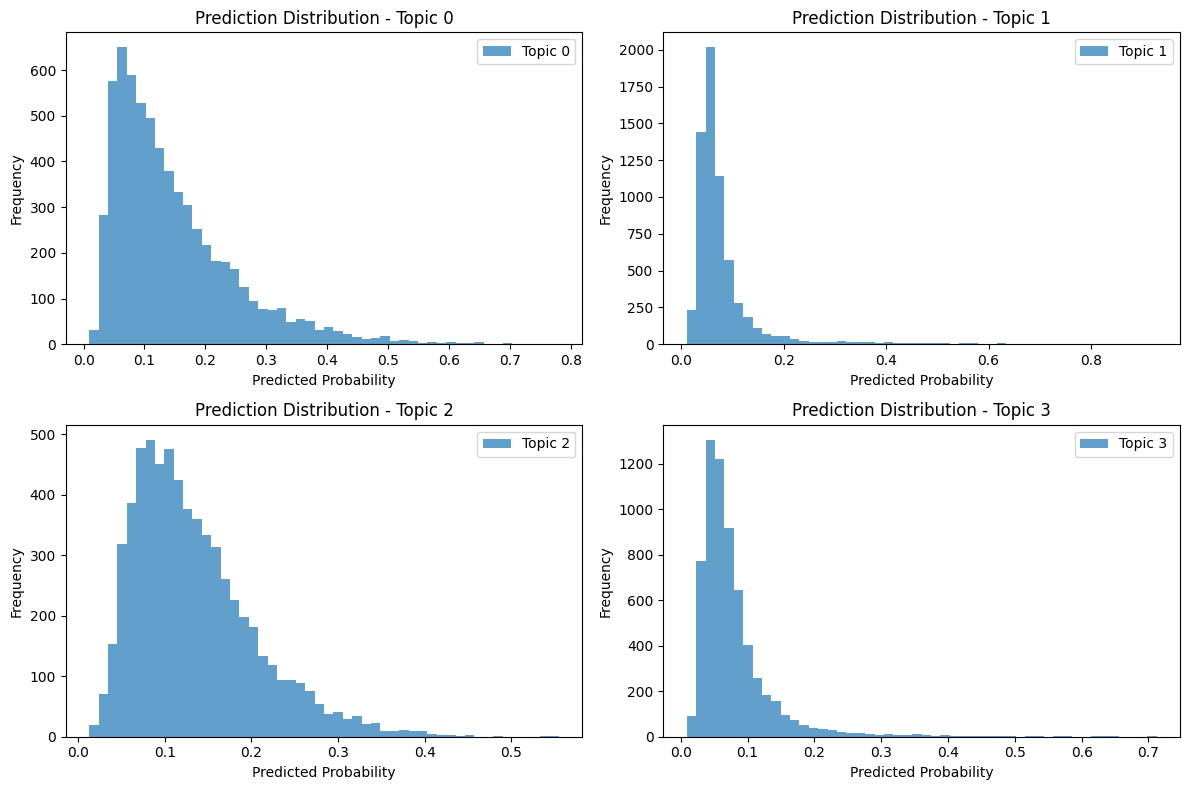


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.05402023 0.03341322 0.07493946 0.03082997 0.07498968 0.14773324
 0.3240568  0.06645239 0.04281202 0.06139773 0.07228587 0.05327208
 0.13276032 0.07705828 0.04957395 0.11299727 0.22170691 0.23068197]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.23695897 0.12651727 0.07816248 0.12000267 0.18955068 0.08714636
 0.08891504 0.08853506 0.08391168 0.07527552 0.05894615 0.08220073
 0.21454872 0.1498618  0.11199667 0.11713606 0.07572299 0.15839678]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.14817408 0.04139403 0.10366255 0.04184542 0.05290606 0.16295373
 0.1337433  0.09264246 0.04773953 0.10702697 0.10630739 0.03924848
 0.07183696 0.04212757 0.06059802 0.27522805 0.12548667 0.04037526]
  Actual:    [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.

In [30]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()